In [8]:
import numpy as np 
import musclebeachtools as mbt
import neuraltoolkit as ntk
import pandas as pd
import seaborn as sns
import os
import glob

from copy import deepcopy as cdc
from sys import platform
from datetime import datetime
import datetime as dt
import time

from criticality import exclude as ex
import criticality as cr


import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import plotly
import plotly.graph_objects as go

import scipy
import scipy.stats as stats
from scipy.stats import sem
import scipy.io as sio

import sahara_work as saw

import math

import statsmodels.api as sm
from statsmodels.formula.api import ols

import sklearn
from sklearn.metrics import f1_score,v_measure_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score

from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from matplotlib.collections import PolyCollection


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

if platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'
    
pth = f'/{basedir}/HlabShare/james/'

savedir = f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/'
today = datetime.today().strftime('%Y-%m-%d')

cmap = "YlGnBu"

SAVEFIGS = 0

plt.style.use('default')



In [9]:
# Load dataframe with all of the DCC information in it.
dfall = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/indv_param_with_dist8_justca1_v13.pkl')

dfall = dfall.drop_duplicates(subset=['animal','probe', 'date', 'time_frame', 'block_num', 'scored'], keep = 'last')

df = dfall
df.sort_values(by=['animal', 'age'])
dfpassed = df[df.passed == True]

df['bin'] = pd.cut(x=df['age_days'], bins= [0,91,274,600],labels=['Young','Mid','Old'])


In [10]:
# # Load dataframe with all of the DCC information in it.
# dfall = pd.read_pickle(f'/{basedir}/HlabShare/te4_manuscript_james/indv_param_with_dist8_justca1_v13.pkl')

# dfall = dfall.drop_duplicates(subset=['animal','probe', 'date', 'time_frame', 'block_num', 'scored'], keep = 'last')

# df = dfall
# df.sort_values(by=['animal', 'age'])
# dfpassed = df[df.passed == True]

# df['bin'] = pd.cut(x=df['age_days'], bins= [0,91,274,600],labels=['Young','Mid','Old'])
# df_ = df
# #df_ = df_[df_.dcc < 1]
# df_ = df_.replace('e4','wt')
# df_ = df_.sort_values(by=['geno'])
# dcc_lmer = df_


# # Define a function to categorize age
# def categorize_age(age):
#     if age < 91:
#         return 'young'
#     elif 91 <= age <= 274:
#         return 'mid'
#     else:
#         return 'old'

# # Apply the function to the age column to create the age_group column
# dcc_lmer['age_group'] = dcc_lmer['age_days'].apply(categorize_age)
# #dcc_lmer = dcc_lmer[dcc_lmer.num_cells >= 10]


In [11]:
#dcc_lmer.to_pickle('/media/HlabShare/james_work/DCC_df_for_Aidan_nofilters.pkl')

In [12]:
def extract_AV(FR_mat, start, end, threshold):
    sm_fr = FR_mat[:,start:end]

    n,m = np.shape(sm_fr)
    positions =[]
    for cell in sm_fr:
        positions.append(np.where(cell>0)[0] + 0.5)

    network = np.nansum(sm_fr, axis=0)
    sortN = np.sort(network)
    # threshold = sortN[round(m*perc)]
    thresh_max = np.ma.masked_where(network<=threshold, network)

    zdata = cdc(network)
    zdata[~thresh_max.mask] = 1 #avalanches
    zdata[thresh_max.mask] = 0 #intervals

    Z1 = np.where(~thresh_max.mask)[0] #avalanches
    Z  = np.where(thresh_max.mask)[0] #intervals

    edges = np.diff(zdata)
    ontimes = np.where(edges>0)[0]
    offtimes = np.where(edges<0)[0]

    if zdata[0]==1:
        ontimes = np.insert(ontimes, 0, 0)
    if zdata[-1]==1:
        offtimes =np.append(offtimes,len(edges))
        
    return threshold,network,positions,ontimes,offtimes


def scaling_plots(Result, burst, burstMin, burstMax, alpha, T, tMin, tMax,
                  beta, TT, Sm, sigma, fit_sigma, pltname, saveloc, p_val_b, p_val_t, burst_shuff, T_shuff):
    
    FontsizeForAll = 14
    burstMax = int(burstMax)
    burstMin = int(burstMin)
    fig1, ax1 = plt.subplots(nrows = 1, ncols = 3, figsize = [10, 3])
    
    
    # burst PDF
    pdf = np.histogram(burst, bins = np.arange(1, np.max(burst) + 2))[0]
    p = pdf / np.sum(pdf)
    ax1[0].plot(np.arange(1, np.max(burst) + 1), p, marker = 'o',
                markersize = 2, fillstyle = 'none', mew = .5,
                linestyle = 'none', color = 'darkorchid', alpha = 0.75)
    ax1[0].plot(np.arange(1, np.max(burst) + 1)[burstMin:burstMax],
                p[burstMin:burstMax], marker = 'o', markersize = 2,
                fillstyle = 'full', linestyle = 'none', color = 'darkorchid',
                alpha = 0.75)
    
    ax1[0].set_yscale('log')
    ax1[0].set_xscale('log')
    ax1[0].xaxis.get_minor_locator().set_params(numticks=500, subs=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

    #x = np.arange(burstMin, burstMax + 1)
    x = np.linspace(burstMin,burstMax+1, len(p))
    y = (np.size(np.where(burst == burstMin + 6)[0]) / np.power(burstMin + 6, -alpha)) *\
        np.power(x, -alpha)
    y = y / np.sum(pdf)
    
    #pdb.set_trace()
    y_actual = []
    y_predicted = []
    MSE = []
    RMSE = []
    y_actual = p
    y_predicted = y
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    RMSE = MSE**0.5
    
    # not truly the max, cause we pass in the truncated dataset
    xmax = np.max(burst)
    n = np.size(burst)
    cdf = np.cumsum(np.histogram(burst, np.arange(burstMin, xmax+2))[0]/n)
    s = np.unique(burst)
    A = 1/np.sum(np.power(s, -alpha))
    fit = np.cumsum(A*np.power(np.arange(burstMin, xmax+1), -alpha))
    KS = np.max(np.abs(cdf-fit))

    ax1[0].plot(x, y, color = '#c5c9c7')
    
    sh_pdf = np.histogram(burst_shuff, bins = np.arange(1, np.max(burst_shuff) + 2))[0]
    sh_p = sh_pdf / np.sum(sh_pdf)
    ax1[0].plot(np.arange(1, np.max(burst_shuff) + 1), sh_p, color='gray', alpha = 0.25)
    ax1[0].set_xlabel('Avalanche size', fontsize=FontsizeForAll)
    ax1[0].set_ylabel('PDF(S)', fontsize=FontsizeForAll)
    ax1[0].set_title(r'$\alpha$=' + str(np.round(alpha, 1)) + '\n KS stat. =' + str(round(KS,2)), fontsize=FontsizeForAll)
    #ax.set_title('Normalized occupied \n Neighbors')
    #ax1[0].text(10, .001, str(RMSE))
    if p_val_b is not None:
        ax1[0].text(10, .1, f'p_val = {p_val_b}')

    # time pdf
    tdf = np.histogram(T, bins = np.arange(1, np.max(T) + 2))[0]
    t = tdf / np.sum(tdf)
    ax1[1].plot(np.arange(1, np.max(T) + 1), t, marker = 'o',
                markersize = 2, fillstyle = 'none', mew = .5,
                linestyle = 'None', color = 'mediumseagreen', alpha = 0.75)
    ax1[1].plot(np.arange(1, np.max(T) + 1)[tMin:tMax], t[tMin:tMax],
                marker = 'o', markersize = 2, fillstyle = 'full',
                linestyle = 'none', color = 'mediumseagreen', alpha = 0.75)
    ax1[1].set_yscale('log')
    ax1[1].set_xscale('log')
    sns.despine()

    #x = np.arange(tMin, tMax + 1)
    x = np.linspace(tMin,tMax+1, len(t))
    y = np.size(np.where(T == tMin)) / (np.power(tMin, -beta)) *\
        np.power(x, -beta)
    y = y / np.sum(tdf)
    
    y_actual = []
    y_predicted = []
    MSE = []
    RMSE = []
    y_actual = t
    y_predicted = y
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    RMSE = MSE**0.5
    
    # not truly the max, cause we pass in the truncated dataset
    xmax = np.max(T)
    n = np.size(T)
    cdf = np.cumsum(np.histogram(T, np.arange(tMin, xmax+2))[0]/n)
    s = np.unique(T)
    A = 1/np.sum(np.power(s, -alpha))
    fit = np.cumsum(A*np.power(np.arange(tMin, xmax+1), -alpha))
    KS = np.max(np.abs(cdf-fit))
    
    ax1[1].plot(x, y, color = '#c5c9c7')
    
    sh_pdf = np.histogram(T_shuff, bins = np.arange(1, np.max(T_shuff) + 2))[0]
    sh_p = sh_pdf / np.sum(sh_pdf)
    ax1[1].plot(np.arange(1, np.max(T_shuff) + 1), sh_p, color='gray', alpha = 0.25)
    
    ax1[1].set_xlabel('Avalanche duration', fontsize=FontsizeForAll)
    ax1[1].set_ylabel('PDF(D)', fontsize=FontsizeForAll)
    plt.rcParams['pdf.fonttype'] = 42
    ax1[1].set_title(r'$\beta$=' + str(np.round(beta, 1)) + '\n KS stat. =' + str(round(KS,2)), fontsize=FontsizeForAll)
    #ax1[1].text(10, .001, 'testing')
    if p_val_t is not None:
        ax1[1].text(10, .1, f'p_val = {p_val_t}')


    # figure out how to plot shuffled data
    
    

    # scaling relation
    i = np.where(TT == tMax)  # just getting the last value we use, getting rid of the hard codes
    ax1[2].plot(TT, ((np.power(TT, sigma) / np.power(TT[7], sigma)) * Sm[7]),
                label = 'pre', color = '#4b006e')
    ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),
                'b', label = 'fit', linestyle = '--', color = '#826d8c')
    ax1[2].plot(TT, Sm, 'o', color = '#fb7d07', markersize = 2, mew = .5,
                fillstyle = 'none', alpha = 0.75)

    locs = np.where(np.logical_and(TT < tMax, TT > tMin))[0]

    ax1[2].plot(TT[locs], Sm[locs], 'o', markersize = 2, mew = .5,
                color = '#fb7d07', fillstyle = 'full', alpha = 1)
    ax1[2].set_xscale('log')
    ax1[2].set_yscale('log')
    ax1[2].set_ylabel('<S>', fontsize=FontsizeForAll)
    ax1[2].set_xlabel('Duration', fontsize=FontsizeForAll)
    ax1[2].set_title('DCC = ' + str(np.round(Result['df'], 3)), fontsize=FontsizeForAll)

    ax1[0].tick_params(axis='both', which='major', labelsize=12)
    ax1[1].tick_params(axis='both', which='major', labelsize=12)
    ax1[2].tick_params(axis='both', which='major', labelsize=12)
    #ax1[0].tick_params(axis='both', which='minor', labelsize=25)
    
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    
    plt.legend(fontsize = 10)
    # plt.savefig(saveloc + "/" + pltname + 'scaling_relations' + '.svg', format='svg')
    #savefigpath = op.join(saveloc , pltname + 'scaling_relations' + '.svg')
    #print("savefigpath ", savefigpath)
    #plt.savefig(savefigpath, format='svg')

    return fig1


def AV_analysis(burst, T, burst_shuff, T_shuff, flag = 1, bm=1, tm=1, nfactor_bm=1, nfactor_tm=1,
                nfactor_bm_tail=1, nfactor_tm_tail=1, none_fact=40,
                max_time=7200, verbose = True, exclude = False, exclude_burst = 50, 
                exclude_time = 20, exclude_diff_b=20, exclude_diff_t=10, plot=True, pltname='', saveloc=''):
    
    #print('VERBOSE: ', verbose)

    if bm is None:
        if verbose:
            print('none_fact ', none_fact)
        bm = int(np.max(burst)/none_fact)

    Result = {}
    burstMax, burstMin, alpha = \
        ex.EXCLUDE(burst[burst < np.power(np.max(burst), nfactor_bm_tail)], bm,
                   nfactor=nfactor_bm, verbose = verbose)
    idx_burst = \
        np.where(np.logical_and(burst <= burstMax, burst >= burstMin))[0]
    # print("burst[idx_burst] ", burst[idx_burst])
    # print("idx_burst ", idx_burst)
    if verbose:
        print("alpha ", alpha)
        print("burst min: ", burstMin)
        print("burst max:", burstMax, flush=True)

    Result['burst'] = burst
    Result['alpha'] = alpha
    Result['xmin'] = burstMin
    Result['xmax'] = burstMax

    Result['P_burst'] = None
    Result['EX_b'] = False
    if exclude:
        if burstMin > exclude_burst or (burstMax-burstMin)<exclude_diff_b:
            print(f'This block excluded for burst: xmin {burstMin} diff: {burstMax-burstMin}')
            Result['EX_b'] = True
    
    if flag == 2 and not Result['EX_b']:
        if verbose:
            print("About to do the p val test for burst")
        # pvalue test
        Result['P_burst'], ks, hax_burst, ptest_bmin = \
            pv.pvaluenew(burst[idx_burst], alpha, burstMin, nfactor=nfactor_bm,
                         max_time=max_time, verbose = verbose)

    if tm is None:
        if verbose:
            print('none_fact ', none_fact)
        tm = int(np.max(T)/none_fact)

    # print("tMax, tMin, beta = ex.EXCLUDE(T, tm)")
    # ckbn tMax, tMin, beta = ex.EXCLUDE(T, tm, nfactor=nfactor_tm)
    tMax, tMin, beta = \
        ex.EXCLUDE(T[T < np.power(np.max(T), nfactor_tm_tail)], tm,
                   nfactor=nfactor_tm, verbose = verbose)
    idx_time = np.where(np.logical_and(T >= tMin, T <= tMax))[0]

    if verbose:
        print("beta ", beta)
        print(f'time min: {tMin}')
        print(f'time max: {tMax}', flush=True)

    Result['T'] = T
    Result['beta'] = beta
    Result['tmin'] = tMin
    Result['tmax'] = tMax

    Result['P_t'] = None
    Result['EX_t'] = False
    if exclude:
        if tMin > exclude_time or (tMax-tMin)<exclude_diff_t:
            print(f'This block excluded for time: tmin {tMin} diff: {tMax-tMin}')
            Result['EX_t'] = True

    if flag == 2 and not Result['EX_t'] and not Result['EX_b']:
        if verbose:
            print("About to do the p val test for time")
        # pvalue for time
        Result['P_t'], ks, hax_time, ptest_tmin = \
            pv.pvaluenew(T[idx_time], beta, tMin, nfactor=nfactor_tm,
                         max_time=max_time, verbose=verbose)

    TT = np.arange(1, np.max(T) + 1)
    Sm = []
    for i in np.arange(0, np.size(TT)):
        Sm.append(np.mean(burst[np.where(T == TT[i])[0]]))
    Sm = np.asarray(Sm)
    Loc = np.where(Sm > 0)[0]
    TT = TT[Loc]
    Sm = Sm[Loc]

    # ckbndnt
    fit_sigma = \
        np.polyfit(np.log(TT[np.where(np.logical_and(TT > tMin,
                                                     TT < tMax))[0]]),
                   np.log(Sm[np.where(np.logical_and(TT > tMin,
                                                     TT < tMax))[0]]), 1)
    sigma = (beta - 1) / (alpha - 1)
    if verbose:
        print("fit_sigma ", fit_sigma)
        print("sigma ", sigma, flush=True)


    Result['pre'] = sigma
    Result['fit'] = fit_sigma
    Result['df'] = np.abs(sigma - fit_sigma[0])
    Result['TT'] = TT
    Result['Sm'] = Sm
    Result['burst_cdf'] = None
    Result['time_cdf'] = None
    Result['scaling_relation_plot'] = None 

    if plot:
        fig1 = scaling_plots(Result, burst, burstMin, burstMax, alpha, T,
                             tMin, tMax, beta, TT, Sm, sigma, fit_sigma,
                             pltname, saveloc, Result['P_burst'], Result['P_t'], burst_shuff, T_shuff)
        if flag == 2 and not Result['EX_t'] and not Result['EX_b']:
            hax_burst.axes[0].set_xlabel('Size (S)', fontsize=16)
            hax_burst.axes[0].set_ylabel('Prob(size < S)', fontsize=16)
            # hax_burst.savefig(saveloc + "/" + pltname + 'pvalue_burst' + '.svg', format='svg')
            savefigpathb = op.join(saveloc,  pltname + 'pvalue_burst' + '.svg')
            print("savefigpathb ", savefigpathb)
            hax_burst.savefig(savefigpathb, format='svg')

            hax_time.axes[0].set_xlabel('Duration (D)', fontsize=16)
            hax_time.axes[0].set_ylabel('Prob(size < D)', fontsize=16)
            # hax_time.savefig(saveloc + "/" + pltname + 'pvalue_time' +  '.svg', format='svg')
            savefigpatht = op.join(saveloc, pltname + 'pvalue_time' + '.svg')
            print("savefigpatht ", savefigpatht)
            hax_burst.savefig(savefigpatht, format='svg')
            Result['burst_cdf'] = hax_burst
            Result['time_cdf'] = hax_time
        Result['scaling_relation_plot'] = fig1
        plt.close('all')

    return Result


def spiketimes_to_spikewords(spiketimes,startime,stoptime,binsize,binarize): 
    ### ARGUMENTS
    #spiketimes - list of spiketime arrays where each element of list is for a different neuron (e.g. the output of n_getspikes())
    #startime,stoptime - bounds of time to convert to spikewords (in seconds)
    #binsize - size of bin in milliseconds
    #binarize - '1' to convert to 0's and 1's, '0' to keep as histogram counts
    ### RETURNS
    #array of spikewords with each column as a cell and each rows as time in bins 
    
    #get sec_time to bin conversion factor
    #startime in bins
    startime_ms = startime * 1000
    stoptime_ms = stoptime * 1000
    binrange = np.arange(start = startime_ms,stop = stoptime_ms+1, step = binsize)
    n_cells = len(spiketimes)

    spikewords_array = np.zeros([binrange.shape[0]-1,n_cells])
    for i in range(n_cells):
        spiketimes_cell = spiketimes[i] * 1000. #spiketimes in seconds * 1000 msec/sec
        counts, bins = np.histogram(spiketimes_cell,bins = binrange)
        if binarize == 1:
            #binarize the counts
            counts[counts>0] = 1
        # print(counts.astype(np.int))
        spikewords_array[:,i] = counts
    return(spikewords_array.astype(np.int8).T)



Loading data from first probe

['APT_PCB']
['APT_PCB']


/hlabhome/wg-mjames/tmp/5SgW/ipykernel_84786/4043500314.py:70: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  positions = [ele for ele in positions if ele != []]
/hlabhome/wg-mjames/tmp/5SgW/ipykernel_84786/4043500314.py:70: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  positions = [ele for ele in positions if ele != []]


Avalanche threshold should = 8


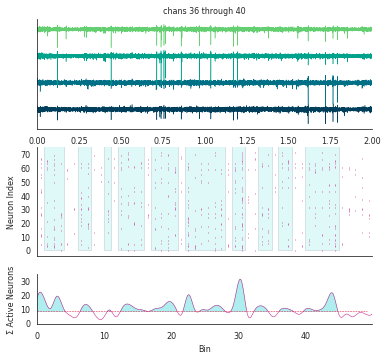

In [13]:
# Bandpass raw data

hstype = ['APT_PCB']
nprobes = 1
number_of_channels = nprobes * 64
fs = 25000

dat_file = f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/Headstages_64_Channels_int16_2020-11-17_00-55-08.bin'


dat_t, dat_dgc = ntk.load_raw_gain_chmap_1probe(dat_file, number_of_channels,
                                       hstype, nprobes=nprobes,
                                       lraw=1, ts=0, te=-1,
                                       probenum=0, probechans=64)

dat_dgcb = ntk.butter_bandpass(dat_dgc, 300, 10000, 25000, 3)


neurons = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/H_2020-11-16_23-05-08_2020-11-17_11-00-08_neurons_group0_scored_clayton.npy', allow_pickle=True)
good_cells = [neuron for neuron in neurons if neuron.quality in [1,2]]
binsize = 0.04

FR_mat = mbt.n_spiketimes_to_spikewords(good_cells, binsz=binsize, binarize=1)

datetime_rawdat = dt.datetime.strptime('2020-11-17_00-55-08', '%Y-%m-%d_%H-%M-%S')
datetime_neurfile = dt.datetime.strptime('2020-11-16_23-05-08', '%Y-%m-%d_%H-%M-%S')
delta_seconds = datetime_rawdat - datetime_neurfile
seconds_offset = delta_seconds.total_seconds()

seconds_offset = seconds_offset + 120


# Make the avalanche example plot with raw data, raster, and threshold example.

sns.set_style('white')

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 5.6), gridspec_kw={'height_ratios': [2.2, 2.2,1]})

t0 = 120
dur = 2
t0 = t0*25000
tend = t0 + (dur*25000)
numbins = int(dur*(1/binsize))

colors = ['#003f5c', '#007086', '#00a28c', '#63cf71']

xvals = np.arange(0,dur, 1/25000)

#---------------------------------------------------------
# Plot the raw data:
count = 0
for e in np.arange(36,40):
    ax[0].plot(xvals, dat_dgcb[e, t0:tend] + count*300, linewidth = 0.5, color = colors[count])
    count +=1
#---------------------------------------------------------

ax[0].set_yticklabels([])
ax[0].tick_params(axis='both', labelsize = 8)
ax[0].set_title(f'chans {36} through {40}', fontsize=8)
ax[0].set_xlim([0, dur])
#ax[0].set_xlabel('time (s)',fontsize=8)
sns.despine(ax=ax[0])

base = 0
start = int(seconds_offset*int((1/binsize)))
end = int(start + dur * int((1/binsize)))

AVthreshold = 8
threshold, network, positions, ontimes, offtimes = extract_AV(FR_mat, base+start, base+end, threshold = AVthreshold)
positions = [ele for ele in positions if ele != []]

xys=[]
widths=[]
heights=[]
for i, on in enumerate(ontimes):
    xys.append((on+1,0))
    widths.append(offtimes[i]-on)    
boxes = [Rectangle(xy, width, FR_mat.shape[0]) for xy, width in zip(xys, widths)]
pc = PatchCollection(boxes,facecolor='paleturquoise', alpha=0.4, edgecolor='slategray', lw = 0.5)

ax[1].eventplot(positions, orientation="horizontal",linelengths = 0.8, linewidths = 0.6, color = 'mediumvioletred')   # linelengths = 0.6
ax[1].add_collection(pc)
ax[1].set_xticklabels([])
ax[1].tick_params(axis='both', labelsize = 8)
ax[1].set_ylabel("Neuron Index",fontsize = 8)
ax[1].set_xlim(0,numbins)
ax[1].set_yticks(np.arange(0,79,10))

network = np.insert(network,[0],network[0])
network = np.insert(network,[-1],network[-1])
tn, new_network = ntk.data_intpl(np.arange(0,network.shape[0],1), network, 10, intpl_kind='cubic')

ax[2].plot(np.linspace(0,numbins,len(new_network)), new_network, lw = 0.5, color = 'mediumvioletred')
ax[2].axhline(y= threshold, xmin = 0, xmax = 0.985, color='crimson', linestyle='--', lw = 0.5)
ax[2].fill_between(np.linspace(0,numbins,len(new_network)), threshold, new_network, where=new_network>=threshold, color = 'paleturquoise')

ax[2].tick_params(axis='both',labelsize = 8)
ax[2].set_ylabel('\u03A3 Active Neurons',fontsize = 8) # unicode for capital sigma
ax[2].set_xlabel("Bin",fontsize = 8)
ax[2].set_xlim(0,numbins)
ax[2].set_ylim(-1,35)
ax[2].set_xticks(np.arange(0,numbins,10))
ax[2].set_xticklabels([str(i) for i in np.arange(0,numbins,10)], fontsize=8)
ax[2].set_yticks(np.arange(0,35,10))

sns.despine(ax= ax[0])
sns.despine(ax= ax[1])
sns.despine(ax= ax[2])

if SAVEFIGS:
    fig.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_CAF60_avalanches_{dur}s_rawdata_plus_avalanches.pdf')


print(f'Avalanche threshold should = {round(np.percentile(new_network,35))}')

#seconds_offset = seconds_offset + 120


Data has 53 neurons with length 180000*binsize
perc_threshold  5
Time took in get_avalanches is 0.11889910697937012 seconds
Data has 53 neurons with length 180000*binsize
perc_threshold  7
Time took in get_avalanches is 0.16735100746154785 seconds


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/hlabhome/wg-mjames/tmp/5SgW/ipykernel_84786/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),


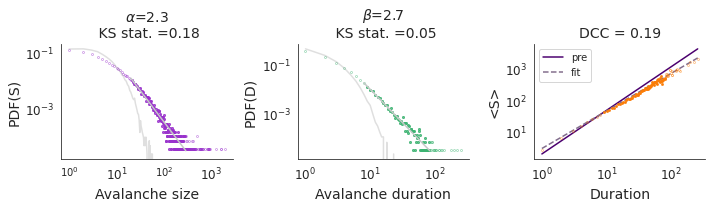

In [14]:
whichanimal = 'kdr14'
whichblock = 11

neurons = np.load(f'/{basedir}/HlabShare/Clustering_Data/KDR00014/kdr14_10182021/112_120/probe1/co/H_2021-10-23_05-41-24_2021-10-23_13-36-24_neurons_group0.npy', allow_pickle=True)

good_cells = []
for a in neurons:
    if a.quality < 3:
        good_cells.append(a)
        
start_hr = 6
end_hr = 8

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r = cr.get_avalanches(spkwords, .35)
S = r['S']
T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']


#S = df[df.animal == whichanimal].iloc[whichblock]['burst']
#T = df[df.animal == whichanimal].iloc[whichblock]['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)

#fig1 = scaling_plots(Result, burst, burstMin, burstMax, alpha, T,
#                             tMin, tMax, beta, TT, Sm, sigma, fit_sigma,
#                             pltname, saveloc, Result['P_burst'], Result['P_t'], burst_shuff, T_shuff)

#Make plots of the distributions and scaling relation (DCC)

plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')

analysisResults['scaling_relation_plot']


Data has 64 neurons with length 180000*binsize
perc_threshold  14
Time took in get_avalanches is 0.0446474552154541 seconds
Data has 64 neurons with length 180000*binsize
perc_threshold  16
Time took in get_avalanches is 0.16276812553405762 seconds


/hlabhome/wg-mjames/tmp/5SgW/ipykernel_84786/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),


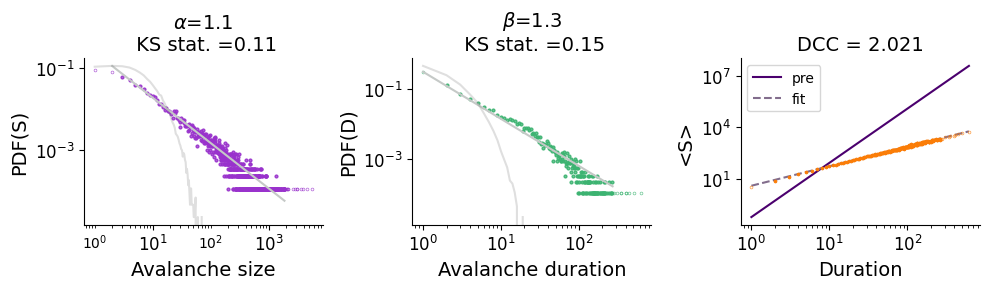

In [33]:
# This generates another example avalanche distribution plot - OLD TE4
whichanimal = 'caf37'
whichblock = 5

tmp_neurons = np.load(f'/{basedir}/HlabShare/Clustering_Data/CAF00037/caf37_08272020/16_24/probe1/co/H_2020-08-28_09-02-55_2020-08-28_16-57-55_neurons_group0_scored_clayton.npy', allow_pickle=True)

good_cells = []
fr_cutoff = 50
good_cells = [tmp_neurons for tmp_neurons in tmp_neurons if tmp_neurons.quality < 3 and tmp_neurons.plotFR(binsz=tmp_neurons.end_time, lplot=0, lonoff=0)[0][0] < fr_cutoff and tmp_neurons.presence_ratio() > .99]

        
start_hr = 2
end_hr = start_hr+2

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r = cr.get_avalanches(spkwords, .35)
S = r['S']
T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']


#S = df[df.animal == whichanimal].iloc[whichblock]['burst']
#T = df[df.animal == whichanimal].iloc[whichblock]['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)


#Make plots of the distributions and scaling relation (DCC)

plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')

analysisResults['scaling_relation_plot']
    

Data has 64 neurons with length 180000*binsize
perc_threshold  16
Time took in get_avalanches is 0.17438030242919922 seconds


/hlabhome/wg-mjames/tmp/5SgW/ipykernel_84786/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),


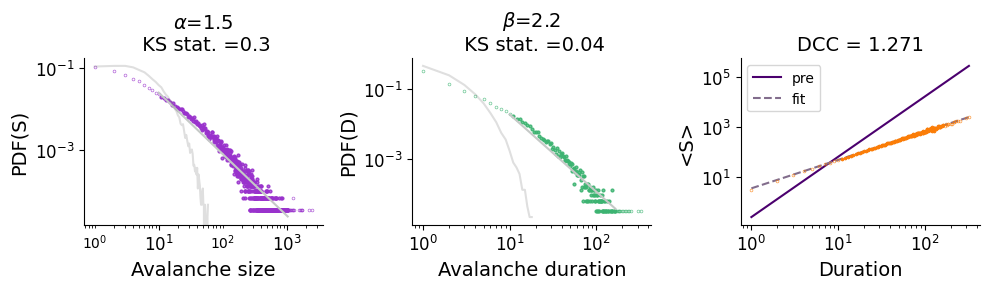

In [36]:
whichanimal = 'caf37'
whichblock = 5

S = df[df.animal == whichanimal].iloc[whichblock]['burst']
T = df[df.animal == whichanimal].iloc[whichblock]['T']

#SizeKS = df[df.animal == whichanimal].iloc[whichblock]['KS_burst']
#DurationKS = df[df.animal == whichanimal].iloc[whichblock]['KS_t']

tmp_neurons = np.load(f'/{basedir}/HlabShare/Clustering_Data/CAF00037/caf37_08272020/16_24/probe1/co/H_2020-08-28_09-02-55_2020-08-28_16-57-55_neurons_group0_scored_clayton.npy', allow_pickle=True)

good_cells = []
fr_cutoff = 50
good_cells = [tmp_neurons for tmp_neurons in tmp_neurons if tmp_neurons.quality < 3 and tmp_neurons.plotFR(binsz=tmp_neurons.end_time, lplot=0, lonoff=0)[0][0] < fr_cutoff and tmp_neurons.presence_ratio() > .99]

        
start_hr = 2
end_hr = start_hr+2

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

# spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
# r = cr.get_avalanches(spkwords, .35)
# S = r['S']
# T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)


#Make plots of the distributions and scaling relation (DCC)


plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')


analysisResults['scaling_relation_plot']




In [37]:
SAVEFIGS = 0

In [32]:
df[df.animal == whichanimal].iloc[whichblock]

level_0                                                    272.0
index                                                        0.0
animal                                                     caf37
probe                                                     probe1
date                                                      082720
time_frame                                                 16_24
block_num                                                      1
scored                                                       xgb
bday                                         2019-08-18 07:30:00
rstart_time                                  2020-08-28 09:02:55
age                                            376 days 03:32:55
geno                                                         te4
p_val_b                                                      0.0
p_val_t                                                      0.0
dcc                                                     1.270572
alpha                    

# Measure mean DCC in 3-week bins and make bar plot:

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid valu

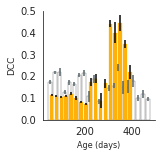

In [66]:
figa, axa = plt.subplots(ncols = 1, nrows = 1, figsize = [2,2])

# Generate the binned mean DCCs over time:

dcc_df = []
dcc_df = df[df.dcc < 10]
dcc_df = dcc_df.replace('e4','wt')
dcc_df = dcc_df.sort_values(by='age_days')

#dcc_df = dcc_lmer

bins = np.arange(50,530,21)
dcc_df['bin'] = pd.cut(dcc_df['age_days'], bins)

justpassed = 'False'
if justpassed == 'True':
    dcc_df = dcc_df[dcc_df.passed == True]
else:
    dcc_df = dcc_df

wtmeans = []
te4means = []
wtsems = []
te4sems = []
all_wt_dccs = []
all_te4_dccs = []

for a in np.arange(0,len(bins)-1):
    tmpdf = []
    tmpdf = dcc_df[dcc_df.age_days > bins[a]]
    tmpdf = tmpdf[tmpdf.age_days < bins[a+1]]
    wtmeans.append(tmpdf[tmpdf.geno == 'wt'].dcc.mean())
    te4means.append(tmpdf[tmpdf.geno == 'te4'].dcc.mean())
    all_wt_dccs.append(np.array(tmpdf[tmpdf.geno == 'wt'].dcc))
    all_te4_dccs.append(np.array(tmpdf[tmpdf.geno == 'te4'].dcc))
    wtsems.append(scipy.stats.sem(tmpdf[tmpdf.geno == 'wt'].dcc))
    te4sems.append(scipy.stats.sem(tmpdf[tmpdf.geno == 'te4'].dcc))

# WT
axa.bar(bins[:-1], wtmeans, width = 15, color=[], edgecolor = 'black', lw = 0.25, alpha=1)
axa.errorbar(bins[:-1], wtmeans, wtsems, linestyle='None', color=sns.xkcd_rgb['gunmetal'] )

# TE4
axa.bar(bins[:-1]+7, te4means, width = 15, color=sns.xkcd_rgb['saffron'], edgecolor=sns.xkcd_rgb['saffron'], lw = 0.25, alpha=1)
axa.errorbar(bins[:-1]+7, te4means, te4sems, linestyle='None', color='black')

axa.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize = 8)
axa.set_xlabel('Age (days)', fontsize=8)

axa.set_ylim([0,.5])
axa.set_ylabel('DCC', fontsize=9)

sns.despine()

if SAVEFIGS:
    figa.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_DCC_3weekbinned_means_oneplot.pdf')
    
    

In [69]:
all_wt_dccs[0]

array([1.36320704e-01, 1.86081443e-01, 3.38207787e-01, 5.11878285e-02,
       1.55562289e-01, 2.71522565e-02, 1.08513872e-01, 3.46824217e-01,
       3.85086124e-02, 4.38167979e-01, 5.24228979e-02, 4.82088756e-02,
       4.26984207e-01, 9.56707110e-02, 4.44802975e-01, 6.65434842e-01,
       9.12035093e-02, 4.03480919e-02, 1.63836653e-01, 2.92044674e-02,
       1.20203870e-01, 9.49972052e-01, 3.12037721e-01, 2.45720164e-02,
       4.74564732e-02, 1.21687688e-01, 8.01372808e-03, 2.67738782e-01,
       1.42431217e-02, 1.29229577e-01, 5.27235479e-02, 1.25699712e-02,
       2.65628273e-01, 5.51104502e-02, 5.64113268e-02, 9.79303604e-02,
       8.66331380e-02, 2.64636807e-01, 5.81235775e-02, 9.38727184e-02,
       3.02599027e-01, 1.69933197e-01, 1.10559375e-02, 4.35966279e-01,
       2.91135659e-02, 2.86701887e-01, 3.44443471e-02, 1.25746703e-01,
       1.37642534e-01, 5.23885738e-03, 4.81714553e-01, 3.39493622e-02,
       1.81705925e-01, 1.31629281e-01, 3.35522305e-01, 2.41181103e-02,
      

In [68]:
all_te4_dccs

[array([9.93440743e-02, 6.02491427e-02, 5.79277194e-02, 2.15936570e-01,
        1.32929578e-01, 8.05066299e-02, 9.87350896e-02, 1.41622438e-02,
        1.57106794e-02, 1.44259929e-01, 1.44390865e-01, 9.26180607e-02,
        4.47279565e-02, 1.45323517e-01, 2.19254778e-01, 3.60911458e-02,
        1.23313118e-01, 1.69206024e-01, 5.77603076e-02, 5.30404114e-02,
        6.76803992e-01, 1.65711373e-01, 2.55146912e-01, 5.52957246e-02,
        1.51054689e-01, 1.14514793e-01, 2.67091555e-02, 6.25698241e-02,
        1.55284558e-01, 8.61702122e-03, 3.01832212e-01, 5.21156367e-03,
        1.70925741e-01, 8.18385351e-02, 1.34336570e-01, 7.65469465e-02,
        9.29712401e-02, 2.28771076e-02, 2.65955254e-02, 9.64130003e-02,
        8.57437094e-02, 2.20283975e-01, 4.47895554e-02, 2.00612862e-01,
        4.05429083e-01, 2.91254617e-01, 6.39535035e-02, 6.24012635e-01,
        2.09792224e-03, 1.66529145e-01, 1.04589108e-01, 2.18884321e-02,
        2.01356456e-01, 3.08280140e-02, 2.27872513e-02, 1.052725

# LMER deep dive plots on DCC data:

In [9]:
pd.read_csv('2023-08-15_dcc_lmer_grouped_e4_wt.csv')

,Unnamed: 0,level_0,index,animal,probe,date,time_frame,block_num,scored,bday,...,br2,burst,T,num_cells,npy_file,region,age_days,phase,bin,age_group
0,0,0.0,0.0,caf72,probe1,32421,0_4,0,xgb,2020-11-24 07:30:00,...,0.990598,[3 1 7 ... 3 5 1],[3 1 4 ... 1 3 1],5,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,120.155208,B,Mid,mid
1,5459,5459.0,0.0,caf49,probe1,102120,0_12,2,xgb,2020-07-20 07:30:00,...,0.837950,[ 3 12 3 ... 3 2 13],[2 4 1 ... 1 1 3],39,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,93.470833,B,Mid,mid
2,5458,5458.0,0.0,caf49,probe1,102120,0_12,1,xgb,2020-07-20 07:30:00,...,0.824807,[ 1 1 4 ... 13 48 2],[1 1 2 ... 4 8 1],39,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,93.387500,B,Mid,mid
3,5457,5457.0,0.0,caf49,probe1,102120,0_12,0,xgb,2020-07-20 07:30:00,...,0.853024,[ 2 30 2 ... 2 1 1],[1 5 1 ... 1 1 1],39,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,93.304167,B,Mid,mid
4,5452,5452.0,0.0,caf72,probe1,30421,52_56,0,xgb,2020-11-24 07:30:00,...,0.989861,[10 7 2 ... 7 16 2],[ 5 3 2 ... 3 10 2],22,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,102.390197,B,Mid,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8626,0,NaN,NaN,caf40,probe1,91420,36_48,5,xgb,2020-02-20 07:30:00,...,NaN,[ 17 325 79 ... 14 5 3],[ 2 46 11 ... 5 2 1],45,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.327361,B,Mid,mid
8627,0,NaN,NaN,caf40,probe1,91420,36_48,4,xgb,2020-02-20 07:30:00,...,NaN,[ 4 4 5 ... 7 385 50],[ 1 1 2 ... 3 57 8],45,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.244028,B,Mid,mid
8628,0,NaN,NaN,caf40,probe1,91420,36_48,3,xgb,2020-02-20 07:30:00,...,NaN,[ 1 2 4 ... 20 1 2],[1 1 1 ... 5 1 1],45,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.160694,B,Mid,mid
8629,0,NaN,NaN,caf40,probe1,91420,48_60,4,xgb,2020-02-20 07:30:00,...,NaN,[ 3 1 1 ... 68 12 105],[ 1 1 1 ... 14 4 20],28,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.744028,B,Mid,mid


In [6]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-15_dcc_lmer_grouped_e4_wt.csv'
dcc_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
dcc_lmer = lmer(dcc ~ age_group * geno + (1|animal), data = dcc_data)


New names:
• `` -> `...1`
Rows: 8631 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): animal, probe, date, time_frame, scored, age, geno, fit_sigma, bu...
dbl  (30): ...1, level_0, index, block_num, p_val_b, p_val_t, dcc, alpha, be...
lgl   (3): passed, excluded_b, excluded_t
dttm  (2): bday, rstart_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
%%R

# Compute the estimated marginal means
emm <- emmeans(dcc_lmer, ~ age_group * geno)


emm_df <- as.data.frame(emm)
# Keep only relevant columns
emm_df <- emm_df[, c("geno", "age_group", "emmean", "SE")]

# Pairwise comparisons
contrast_results <- pairs(emm)

# Adjust for multiple comparisons
contrast_results_adjusted <- summary(contrast_results, adjust = "bonferroni")

# Display the results
print(contrast_results_adjusted)

# make a dataframe and write it to a csv for loading in python
emm_df <- as.data.frame(emm)
# Keep only relevant columns
emm_df <- emm_df[, c("geno", "age_group", "emmean", "SE")]
write.csv(emm_df, "emmeans_data_JUST_AGE_DCC.csv", row.names = FALSE)


 contrast             estimate      SE  df z.ratio p.value
 mid te4 - old te4    -0.19399 0.05122 Inf  -3.787  0.0023
 mid te4 - young te4  -0.00337 0.00782 Inf  -0.431  1.0000
 mid te4 - mid wt     -0.01638 0.03671 Inf  -0.446  1.0000
 mid te4 - old wt     -0.01004 0.03979 Inf  -0.252  1.0000
 mid te4 - young wt   -0.07682 0.03703 Inf  -2.075  0.5703
 old te4 - young te4   0.19062 0.05151 Inf   3.700  0.0032
 old te4 - mid wt      0.17762 0.04454 Inf   3.988  0.0010
 old te4 - old wt      0.18396 0.04711 Inf   3.905  0.0014
 old te4 - young wt    0.11717 0.04480 Inf   2.615  0.1338
 young te4 - mid wt   -0.01301 0.03711 Inf  -0.350  1.0000
 young te4 - old wt   -0.00666 0.04016 Inf  -0.166  1.0000
 young te4 - young wt -0.07345 0.03743 Inf  -1.962  0.7460
 mid wt - old wt       0.00634 0.02533 Inf   0.250  1.0000
 mid wt - young wt    -0.06045 0.01254 Inf  -4.821  <.0001
 old wt - young wt    -0.06679 0.02688 Inf  -2.485  0.1943

Degrees-of-freedom method: asymptotic 
P value adjustme

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8631' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8631)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8631' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8631)' or larger];
but be warned that this may result in large computation time and memory use.


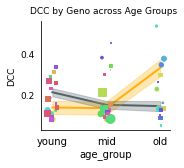

In [28]:
# Create a figure and axes for each cell_type and state
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=[2.3, 2])
emm_df = pd.read_csv('emmeans_data_JUST_AGE_DCC.csv')

# Assuming emm_df is your dataframe
emm_df['age_group'] = pd.Categorical(emm_df['age_group'], categories=['young', 'mid', 'old'], ordered=True)

# data df
df = pd.read_csv('2023-08-15_dcc_lmer_grouped_e4_wt.csv')

# Convert age_group to categorical and order it
df['age_group'] = pd.Categorical(df['age_group'], categories=['young', 'mid', 'old'], ordered=True)


# Define color palette for geno categories
palette = {'te4': '#FEB209', 'wt': '#536267', '.': 'gray'}  # Include '.' for missing key

# Calculate the animal-level means
animal_means = df.groupby(['animal', 'age_group', 'geno'])['dcc'].mean().reset_index()

# Define a color palette for the animals
animals = animal_means['animal'].unique()
animal_palette = dict(zip(animals, sns.color_palette("hls", len(animals))))


# Define markers for genotypes
marker = {'te4': 'o', 'wt': 's', '.': '.'}  # Include '.' for missing key

# Calculate the animal-level means and count of contributing rows
animal_means = df.groupby(['animal', 'age_group', 'geno' ])['dcc'].agg(['mean', 'count']).reset_index()
animal_means.rename(columns={'mean': 'dcc', 'count': 'count'}, inplace=True)

animal_means = animal_means.dropna()

# Create the emm lineplot
sns.lineplot(x="age_group", y="emmean", hue="geno", data=emm_df, ax=axs, palette=palette, lw=2, zorder = 1)


emm_data = emm_df
# Add shaded emm error region
for geno in emm_data["geno"].unique():
    subset = emm_data[emm_data["geno"] == geno].sort_values(by="age_group")
    x_coords = subset["age_group"].cat.codes
    axs.fill_between(x_coords, subset["emmean"] - subset["SE"], subset["emmean"] + subset["SE"], color=palette[geno], alpha=0.3, zorder = 1)

# Select animal-level mean data for this cell_type and state
animal_data = animal_means

# Add a small amount of random noise to x values for jitter
jitter = 0.1  # Adjust this value to control the amount of jitter
x_jitter = animal_data['age_group'].cat.codes + np.random.uniform(-jitter, jitter, size=len(animal_data))

# Create scatterplot of animal-level means with jitter and different markers for genotypes
for geno, group in animal_data.groupby('geno'):
    axs.scatter(x=x_jitter[group.index], y=group["dcc"], c=group['animal'].map(animal_palette), 
               marker=marker[geno], s=group['count']*.1, label=geno)  # Multiply 'count' by a scalar to get the right size

# Add y-axis tick labels to the left column
axs.set_ylabel('DCC', fontsize=9)
plt.yticks(fontsize=9
          )
# Remove the legend
axs.legend_.remove()

axs.tick_params(bottom=False, left=False)

# Add super title for the whole figure
plt.suptitle('DCC by Geno across Age Groups', fontsize=9)

# # Adjust layout with reduced padding between subplots
# plt.tight_layout(rect=[0, 0, 0.92, 1], w_pad=0.1, h_pad=0.1)

sns.despine()

if SAVEFIGS:
    fig.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/emmeans_scatter_JUST_AGE_DCC.pdf')

# Display the plot
plt.show()


In [29]:
SAVEFIGS = 0

In [8]:
SAVEFIGS

0

# Make a boxen plot of DCC data:

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


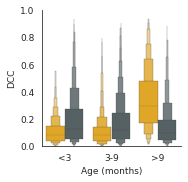

In [6]:
def plotboxen(df_, today, basedir, SAVEFIGS):
    
    plt.figure(figsize=[2.5,2.5])
    #col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]
    col_palette = [sns.xkcd_rgb['saffron'], sns.xkcd_rgb['gunmetal']]

    ax = sns.boxenplot(x = 'bin', y = 'dcc', hue = 'geno', showfliers=False, palette = col_palette, data=df_, linewidth = 0.25)

    plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
    plt.xlabel('Age (months)', fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel('DCC', fontsize=9)
    plt.ylim([0,1.0])
    ax.get_legend().remove()

    sns.despine()

    if SAVEFIGS:
        plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_boxen_dcc.pdf')


df_ = df
df_ = df_[df_.dcc < 1]
df_ = df_.replace('e4','wt')
df_ = df_.sort_values(by=['geno'])
dcc_lmer = df_

plotboxen(df_, today, basedir, SAVEFIGS)


In [9]:
print('wt: ')
print(len(dcc_lmer[(dcc_lmer.passed == True) & (dcc_lmer.dcc <= 0.3) & (dcc_lmer.geno != 'te4')])/len(dcc_lmer[(dcc_lmer.geno != 'te4')]))
print('')

print('te4: ')
print(len(dcc_lmer[(dcc_lmer.passed == True) & (dcc_lmer.dcc <= 0.3) & (dcc_lmer.geno == 'te4')])/len(dcc_lmer[(dcc_lmer.geno == 'te4')]))




wt: 
0.5713063929869574

te4: 
0.575113808801214


In [14]:
print('wt: ')
print(len(dcc_lmer[(dcc_lmer.age_days > 274) & (dcc_lmer.passed == True) & (dcc_lmer.dcc < 0.3) & (dcc_lmer.geno != 'te4')])/len(dcc_lmer[(dcc_lmer.age_days > 274) & (dcc_lmer.geno != 'te4')]))
print('')

print('te4: ')
print(len(dcc_lmer[(dcc_lmer.age_days > 274) & (dcc_lmer.passed == True) & (dcc_lmer.dcc < 0.3) & (dcc_lmer.geno == 'te4')])/len(dcc_lmer[(dcc_lmer.age_days > 274) & (dcc_lmer.geno == 'te4')]))



wt: 
0.6372950819672131

te4: 
0.23909774436090225


In [49]:
print(len(dcc_lmer[(dcc_lmer.geno != 'te4')]))
print(len(dcc_lmer[(dcc_lmer.geno == 'te4')]))

4677
3954


In [33]:
dcc_lmer.animal

0        caf72
5459     caf49
5458     caf49
5457     caf49
5452     caf72
         ...  
0        caf40
0        caf40
0        caf40
0        caf40
0       caf102
Name: animal, Length: 8631, dtype: object

# LMER on DCC data:

In [4]:
df_ = df
df_ = df_[df_.dcc < 1]
df_ = df_.replace('e4','wt')
df_ = df_.sort_values(by=['geno'])
dcc_lmer = df_


# Define a function to categorize age
def categorize_age(age):
    if age < 91:
        return 'young'
    elif 91 <= age <= 274:
        return 'mid'
    else:
        return 'old'

# Apply the function to the age column to create the age_group column
dcc_lmer['age_group'] = dcc_lmer['age_days'].apply(categorize_age)
dcc_lmer = dcc_lmer[dcc_lmer.num_cells >= 10]


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [5]:
dcc_lmer

,level_0,index,animal,probe,date,time_frame,block_num,scored,bday,rstart_time,...,br2,burst,T,num_cells,npy_file,region,age_days,phase,bin,age_group
0,0.0,0.0,caf72,probe1,032421,0_4,0,xgb,2020-11-24 07:30:00,2021-03-24 11:13:30,...,0.990598,"[3, 1, 7, 6, 3, 2, 6, 4, 2, 1, 3, 1, 1, 2, 3, ...","[3, 1, 4, 4, 1, 1, 4, 3, 1, 1, 3, 1, 1, 1, 3, ...",5,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,120.155208,B,Mid,mid
5459,5459.0,0.0,caf49,probe1,102120,0_12,2,xgb,2020-07-20 07:30:00,2020-10-21 14:48:00,...,0.837950,"[3, 12, 3, 1, 6, 23, 9, 9, 4, 2, 48, 5, 14, 4,...","[2, 4, 1, 1, 2, 4, 3, 3, 2, 1, 7, 2, 4, 1, 3, ...",39,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,93.470833,B,Mid,mid
5458,5458.0,0.0,caf49,probe1,102120,0_12,1,xgb,2020-07-20 07:30:00,2020-10-21 14:48:00,...,0.824807,"[1, 1, 4, 19, 2, 1, 6, 1, 2, 3, 1, 1, 74, 7, 2...","[1, 1, 2, 4, 1, 1, 2, 1, 1, 1, 1, 1, 12, 4, 1,...",39,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,93.387500,B,Mid,mid
5457,5457.0,0.0,caf49,probe1,102120,0_12,0,xgb,2020-07-20 07:30:00,2020-10-21 14:48:00,...,0.853024,"[2, 30, 2, 6, 6, 1, 39, 1, 1, 2, 7, 1, 7, 6, 3...","[1, 5, 1, 2, 3, 1, 7, 1, 1, 1, 2, 1, 2, 2, 1, ...",39,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,93.304167,B,Mid,mid
5452,5452.0,0.0,caf72,probe1,030421,52_56,0,xgb,2020-11-24 07:30:00,2021-03-06 16:51:53,...,0.989861,"[10, 7, 2, 11, 3, 3, 5, 8, 6, 2, 2, 6, 11, 1, ...","[5, 3, 2, 4, 2, 1, 2, 2, 3, 2, 2, 2, 6, 1, 1, ...",22,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,102.390197,B,Mid,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,caf40,probe1,091420,36_48,5,xgb,2020-02-20 07:30:00,2020-09-16 05:21:24,...,NaN,"[17, 325, 79, 269, 38, 127, 12, 2, 16, 260, 95...","[2, 46, 11, 48, 7, 21, 2, 1, 3, 46, 12, 11, 12...",45,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.327361,B,Mid,mid
0,NaN,NaN,caf40,probe1,091420,36_48,4,xgb,2020-02-20 07:30:00,2020-09-16 05:21:24,...,NaN,"[4, 4, 5, 2, 15, 16, 2, 14, 20, 7, 1, 15, 8, 9...","[1, 1, 2, 1, 3, 5, 1, 3, 5, 3, 1, 2, 2, 3, 1, ...",45,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.244028,B,Mid,mid
0,NaN,NaN,caf40,probe1,091420,36_48,3,xgb,2020-02-20 07:30:00,2020-09-16 05:21:24,...,NaN,"[1, 2, 4, 10, 4, 1, 1, 5, 3, 2, 12, 3, 4, 15, ...","[1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 4, 1, 2, 6, 6, ...",45,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.160694,B,Mid,mid
0,NaN,NaN,caf40,probe1,091420,48_60,4,xgb,2020-02-20 07:30:00,2020-09-16 17:21:24,...,NaN,"[3, 1, 1, 5, 4, 15, 3, 2, 3, 2, 4, 32, 49, 1, ...","[1, 1, 1, 1, 3, 5, 2, 2, 1, 1, 1, 8, 12, 1, 6,...",28,/media/HlabShare/Clustering_Data/CAF00040/caf4...,NaN,209.744028,B,Mid,mid


In [9]:
new_df = dcc_lmer[['dcc', 'passed', 'animal', 'geno', 'age_days', 'age_group']]

In [10]:
new_df.to_pickle('/media/HlabShare/james_work/DCC_df_for_Aidan.pkl')

In [29]:
dcc_lmer.to_csv(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/{today}_dcc_lmer_grouped_e4_wt.csv')


In [30]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

In [34]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/2023-08-15_dcc_lmer_grouped_e4_wt.csv'
dcc_data <- read_csv(file = fn)

#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
dcc_lmer = lmer(dcc ~ age_group * geno + (1|animal), data = dcc_data)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
New names:
• `` -> `...1`
Rows: 8631 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (15): animal, probe, date, time_frame, scored, age, geno, fit_sigma, bu...
dbl  (30): ...1, level_0, index, block_num, p_val_b, p_val_t, dcc, alpha, be...
lgl   (3): passed, excluded_b, excluded_t
dttm  (2): bday, rstart_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types 

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [35]:
%%R 
# this will provide general information
summary(dcc_lmer)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dcc ~ age_group * geno + (1 | animal)
   Data: dcc_data

REML criterion at convergence: -7680.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8674 -0.5678 -0.2239  0.3453  5.5910 

Random effects:
 Groups   Name        Variance Std.Dev.
 animal   (Intercept) 0.007826 0.08846 
 Residual             0.023513 0.15334 
Number of obs: 8631, groups:  animal, 44

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.386e-01  3.152e-02  3.755e+01   4.396 8.73e-05 ***
age_groupold           1.940e-01  5.122e-02  3.867e+01   3.787 0.000519 ***
age_groupyoung         3.373e-03  7.824e-03  8.623e+03   0.431 0.666357    
genowt                 1.638e-02  3.671e-02  4.160e+01   0.446 0.657758    
age_groupold:genowt   -2.003e-01  5.714e-02  4.868e+01  -3.506 0.000988 ***
age_groupyoung:genowt  5.707e-02  1.478e-02  4.352e+03   

In [36]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(dcc_lmer)


Type III Analysis of Variance Table with Satterthwaite's method
                Sum Sq Mean Sq NumDF  DenDF F value    Pr(>F)    
age_group      0.65207 0.32603     2 94.411 13.8660 5.251e-06 ***
geno           0.02590 0.02590     1 38.695  1.1014    0.3005    
age_group:geno 0.68304 0.34152     2 94.411 14.5246 3.165e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [37]:
%%R
emmresults = emmeans(dcc_lmer, pairwise ~  age_group * geno, adjust = 'tukey')
print(emmresults)


$emmeans
 age_group geno emmean     SE  df asymp.LCL asymp.UCL
 mid       te4   0.139 0.0315 Inf    0.0768     0.200
 old       te4   0.333 0.0404 Inf    0.2535     0.412
 young     te4   0.142 0.0320 Inf    0.0793     0.205
 mid       wt    0.155 0.0188 Inf    0.1181     0.192
 old       wt    0.149 0.0243 Inf    0.1010     0.196
 young     wt    0.215 0.0194 Inf    0.1773     0.253

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$contrasts
 contrast             estimate      SE  df z.ratio p.value
 mid te4 - old te4    -0.19399 0.05122 Inf  -3.787  0.0021
 mid te4 - young te4  -0.00337 0.00782 Inf  -0.431  0.9981
 mid te4 - mid wt     -0.01638 0.03671 Inf  -0.446  0.9978
 mid te4 - old wt     -0.01004 0.03979 Inf  -0.252  0.9999
 mid te4 - young wt   -0.07682 0.03703 Inf  -2.075  0.3006
 old te4 - young te4   0.19062 0.05151 Inf   3.700  0.0030
 old te4 - mid wt      0.17762 0.04454 Inf   3.988  0.0009
 old te4 - old wt      0.18396 0.04711 Inf   3.905  0.0013
 

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8631' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8631)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8631' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8631)' or larger];
but be warned that this may result in large computation time and memory use.


# Make KDE plot of DCC data:

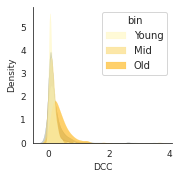

In [31]:
fig, ax = plt.subplots(figsize=[2.5,2.5])

num_samples = 300

boxen_df = df

boxen_wt_df = boxen_df[boxen_df['geno']=='wt']
boxen_wt_df = boxen_wt_df.sort_values(by='age_days')
tmpdf_wt = []
tmpdf_wt = pd.concat([boxen_wt_df[boxen_wt_df.bin == boxen_wt_df.bin.unique()[2]].sample(num_samples), 
           boxen_wt_df[boxen_wt_df.bin == boxen_wt_df.bin.unique()[0]].sample(num_samples),
          boxen_wt_df[boxen_wt_df.bin == boxen_wt_df.bin.unique()[1]].sample(num_samples)])

tmpdf_wt = tmpdf_wt.reset_index(drop=True)

boxen_te4_df = boxen_df[boxen_df['geno']=='te4']
boxen_te4_df = boxen_te4_df.sort_values(by='age_days')
tmpdf_te4 = []
tmpdf_te4 = pd.concat([boxen_te4_df[boxen_te4_df.bin == boxen_te4_df.bin.unique()[2]].sample(num_samples), 
           boxen_te4_df[boxen_te4_df.bin == boxen_te4_df.bin.unique()[0]].sample(num_samples),
          boxen_te4_df[boxen_te4_df.bin == boxen_te4_df.bin.unique()[1]].sample(num_samples)])

tmpdf_te4 = tmpdf_te4.reset_index(drop=True)

sns.kdeplot(data= tmpdf_wt, x='dcc', hue='bin', palette = ['#cfdce1', '#8f9da2', '#536267'], fill=True, common_norm=False, alpha=.6, linewidth=0.1, log_scale = False, ax = ax)
sns.kdeplot(data= tmpdf_te4, x='dcc', hue='bin', palette = ['#fff8bd', '#fbd86e', '#feb209'], fill=True, common_norm=False, alpha=.6, linewidth=0.1, log_scale = False, ax = ax)

ax.set_xlabel('DCC',fontsize=9 )
ax.set_ylabel('Density', fontsize=9 )
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
#ax.get_legend().remove()

sns.despine()


# Run XGBoost on DCC data and make bar plot of results:

In [11]:
all_bas_young = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/all_bas_young.npy')
all_cms_young = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/all_cms_young.npy')
all_bas_mid = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/all_bas_mid.npy')
all_cms_mid = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/all_cms_mid.npy')
all_bas_old = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/all_bas_old.npy')
all_cms_old = np.load(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/te4_figure_3/all_cms_old.npy')




In [85]:
print('young:')
for a in range(len(all_bas_young)):
    print(np.mean(all_bas_young[a])*100)
    print(scipy.stats.sem(all_bas_young[a])*100)
    print('')
    
print('')
print('mid:')
for a in range(len(all_bas_mid)):
    print(np.mean(all_bas_mid[a])*100)
    print(scipy.stats.sem(all_bas_mid[a])*100)
    print('')
    
print('')
print('old:')
for a in range(len(all_bas_old)):
    print(np.mean(all_bas_old[a])*100)
    print(scipy.stats.sem(all_bas_old[a])*100)
    print('')


young:
57.23750000000001
0.9376367421642616

59.35
1.1757703421314458

58.18749999999999
1.2694243976236044

58.575
1.265107424241829

58.11249999999999
1.5761124988319708

61.80000000000001
1.764573021645165

61.150000000000006
1.680983381299508

62.78750000000001
2.0082272687174907

63.849999999999994
1.9220548566039604


mid:
47.59375
0.817630769454176

52.6875
1.1354603357452135

49.787499999999994
1.1664744228288608

49.2
1.3935202668699207

50.94375
1.5781085896502332

53.325
1.9144293032029216

54.96875
1.9155291381118944

53.42500000000001
1.9740624276740666

53.26250000000001
2.0635660842767347


old:
68.08333333333334
1.90659522814484

76.41666666666667
1.6375765900020083

77.63333333333333
1.85182937406537

78.98333333333333
2.1682774737254302

81.10000000000001
1.759440872524009

85.83333333333333
1.80107460472929

83.8
2.1723973726801424

86.75
1.7369794763178483

88.39999999999999
1.3868014965396442



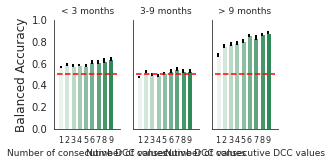

In [12]:
# Make XGBoost figure
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=[4,2])

colorz = sns.light_palette("seagreen",len(all_bas_young))
for a in range(0,len(all_bas_young)):
    ax[0].bar(a,np.mean(all_bas_young[a]),color=colorz[a])
    ax[0].errorbar(a,np.mean(all_bas_young[a]),sem(all_bas_young[a]), color='black', linewidth=2)
    
for a in range(0,len(all_bas_mid)):
    ax[1].bar(a,np.mean(all_bas_mid[a]),color=colorz[a])
    ax[1].errorbar(a,np.mean(all_bas_mid[a]),sem(all_bas_mid[a]), color='black', linewidth=2)
    plt.ylim(0,1)
    
for a in range(0,len(all_bas_old)):
    ax[2].bar(a,np.mean(all_bas_old[a]),color=colorz[a])
    ax[2].errorbar(a,np.mean(all_bas_old[a]),sem(all_bas_old[a]), color='black', linewidth=2)

ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[2].set_ylim([0,1])
ax[0].set_title('< 3 months', fontsize=9)
ax[1].set_title('3-9 months', fontsize=9)
ax[2].set_title('> 9 months', fontsize=9)
ax[0].set_ylabel('Balanced Accuracy', fontsize=12)
ax[0].set_xlabel('Number of consecutive DCC values', fontsize=9)
ax[1].set_xlabel('Number of consecutive DCC values', fontsize=9)
ax[2].set_xlabel('Number of consecutive DCC values', fontsize=9)

ax[0].set_xticks(np.arange(0,len(all_bas_young)),np.arange(1,len(all_bas_young)+1), fontsize=8)
ax[1].set_xticks(np.arange(0,len(all_bas_young)),np.arange(1,len(all_bas_young)+1), fontsize=8)
ax[2].set_xticks(np.arange(0,len(all_bas_young)),np.arange(1,len(all_bas_young)+1), fontsize=8)

ax[1].set_yticks([])
ax[2].set_yticks([])

ax[0].hlines(.5,-.5,len(all_bas_young), linestyles='dashed', color='red')
ax[1].hlines(.5,-.5,len(all_bas_young), linestyles='dashed', color='red')
ax[2].hlines(.5,-.5,len(all_bas_young), linestyles='dashed', color='red')


sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_XGBoost_DCC.pdf')
    
    

# % passed blocks:

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


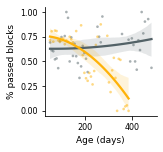

In [4]:
#figa, axa = plt.subplots(ncols = 1, nrows = 2, figsize = [3,3])

dcc_df = []
dcc_df = df
dcc_df = dcc_df.sort_values(by='age_days')

bins = np.arange(50,530,7)
dcc_df['bin'] = pd.cut(dcc_df['age_days'], bins)

wtpassed = []
te4passed = []
  
wt_means_passed = []
wt_sems_passed = []
te4_means_passed = []
te4_sems_passed = []

for a in np.arange(0,len(bins)-1):
    tmpdf = []
    tmpdf = dcc_df[dcc_df.age_days > bins[a]]
    tmpdf = tmpdf[tmpdf.age_days < bins[a+1]]
    
    tmpwt = []
    tmpte4 = []
    
    tmpwt = tmpdf[tmpdf.geno == 'wt']
    tmpte4 = tmpdf[tmpdf.geno == 'te4']
    
    wt_an_bin = []
    if len(tmpwt) > 0:
        for b in tmpwt.animal.unique():
            tmpanimalwt = []
            tmpanimalwt = tmpwt[tmpwt.animal == b]
            wt_an_bin.append(len(tmpanimalwt[tmpanimalwt.passed == True])/len(tmpanimalwt))
    if len(wt_an_bin) > 0:
        wt_means_passed.append(np.mean(wt_an_bin))
        wt_sems_passed.append(scipy.stats.sem(wt_an_bin))
    else:
        wt_means_passed.append(np.nan)
        wt_sems_passed.append(scipy.stats.sem(np.nan))
        
    te4_an_bin = []
    if len(tmpte4) > 0:
        for b in tmpte4.animal.unique():
            tmpanimalte4 = []
            tmpanimalte4 = tmpte4[tmpte4.animal == b]
            te4_an_bin.append(len(tmpanimalte4[tmpanimalte4.passed == True])/len(tmpanimalte4))
    if len(te4_an_bin) > 0:
        te4_means_passed.append(np.mean(te4_an_bin))
        te4_sems_passed.append(scipy.stats.sem(te4_an_bin))
    else:
        te4_means_passed.append(np.nan)
        te4_sems_passed.append(scipy.stats.sem(np.nan))
            
    if len(tmpwt) > 0:
        wtpassed.append(len(tmpwt[tmpwt.passed == True])/len(tmpwt))
    else:
        wtpassed.append(np.nan)
    if len(tmpte4) > 0:
        te4passed.append(len(tmpte4[tmpte4.passed == True])/len(tmpte4))
    else:
        te4passed.append(np.nan)

        
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = [2,2])

ax.scatter(bins[:-1], wtpassed, s=7, color=sns.xkcd_rgb['gunmetal'], alpha = 0.5, edgecolor = [])
ax.scatter(bins[:-1], te4passed, s=7, color=sns.xkcd_rgb['saffron'], alpha = 0.5, edgecolor = [])


tmpdata = {
  "Xs": bins[:-1],
  "wtpassed": wtpassed,
    "te4passed": te4passed,
}

#load data into a DataFrame object:
testdf = pd.DataFrame(tmpdata)
sns.regplot(data = testdf, x = bins[:-1], y = wtpassed, order = 2, color = sns.xkcd_rgb['gunmetal'], scatter=False)
sns.regplot(data = testdf, x = bins[:-1], y = te4passed, order = 2, color = sns.xkcd_rgb['saffron'], scatter=False)

plt.xlabel('Age (days)', fontsize=9)
plt.ylabel('% passed blocks', fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_percentpassed.pdf')
    

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


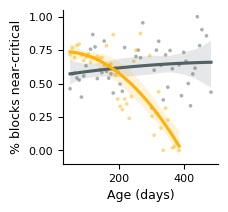

In [40]:
#figa, axa = plt.subplots(ncols = 1, nrows = 2, figsize = [3,3])

dcc_df = []
dcc_df = df
dcc_df = dcc_df.sort_values(by='age_days')
dcc_df = dcc_df.replace('e4', 'wt')

bins = np.arange(50,530,7)
dcc_df['bin'] = pd.cut(dcc_df['age_days'], bins)

wtpassed = []
te4passed = []
  
wt_means_passed = []
wt_sems_passed = []
te4_means_passed = []
te4_sems_passed = []

for a in np.arange(0,len(bins)-1):
    tmpdf = []
    tmpdf = dcc_df[dcc_df.age_days > bins[a]]
    tmpdf = tmpdf[tmpdf.age_days < bins[a+1]]
    
    tmpwt = []
    tmpte4 = []
    
    tmpwt = tmpdf[tmpdf.geno == 'wt']
    tmpte4 = tmpdf[tmpdf.geno == 'te4']
    
    wt_an_bin = []
    if len(tmpwt) > 0:
        for b in tmpwt.animal.unique():
            tmpanimalwt = []
            tmpanimalwt = tmpwt[tmpwt.animal == b]
            wt_an_bin.append(len(tmpanimalwt[(tmpanimalwt.passed == True) & (tmpanimalwt.dcc < .3)])/len(tmpanimalwt))
    if len(wt_an_bin) > 0:
        wt_means_passed.append(np.mean(wt_an_bin))
        wt_sems_passed.append(scipy.stats.sem(wt_an_bin))
    else:
        wt_means_passed.append(np.nan)
        wt_sems_passed.append(scipy.stats.sem(np.nan))
        
    te4_an_bin = []
    if len(tmpte4) > 0:
        for b in tmpte4.animal.unique():
            tmpanimalte4 = []
            tmpanimalte4 = tmpte4[tmpte4.animal == b]
            te4_an_bin.append(len(tmpanimalte4[(tmpanimalte4.passed == True) & (tmpanimalte4.dcc < .3)])/len(tmpanimalte4))
    if len(te4_an_bin) > 0:
        te4_means_passed.append(np.mean(te4_an_bin))
        te4_sems_passed.append(scipy.stats.sem(te4_an_bin))
    else:
        te4_means_passed.append(np.nan)
        te4_sems_passed.append(scipy.stats.sem(np.nan))
            
    if len(tmpwt) > 0:
        wtpassed.append(len(tmpwt[(tmpwt.passed == True) & (tmpwt.dcc < .3)])/len(tmpwt))
    else:
        wtpassed.append(np.nan)
    if len(tmpte4) > 0:
        te4passed.append(len(tmpte4[(tmpte4.passed == True) & (tmpte4.dcc < .3)])/len(tmpte4))
    else:
        te4passed.append(np.nan)

        
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = [2,2])

ax.scatter(bins[:-1], wtpassed, s=7, color=sns.xkcd_rgb['gunmetal'], alpha = 0.5, edgecolor = [])
ax.scatter(bins[:-1], te4passed, s=7, color=sns.xkcd_rgb['saffron'], alpha = 0.5, edgecolor = [])

tmpdata = {
  "Xs": bins[:-1],
  "wtpassed": wtpassed,
    "te4passed": te4passed,
}

#load data into a DataFrame object:
testdf = pd.DataFrame(tmpdata)
sns.regplot(data = testdf, x = bins[:-1], y = wtpassed, order = 2, color = sns.xkcd_rgb['gunmetal'], scatter=False)
sns.regplot(data = testdf, x = bins[:-1], y = te4passed, order = 2, color = sns.xkcd_rgb['saffron'], scatter=False)

plt.xlabel('Age (days)', fontsize=9)
plt.ylabel('% blocks near-critical', fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_percentnearcritical.pdf')
    

In [41]:
SAVEFIGS = 0

In [13]:
wt_an_bin

[]

In [10]:
SAVEFIGS = 0

In [11]:
testdf

,Xs,wtpassed,te4passed
0,50,0.461538,0.714286
1,57,0.572289,0.766234
2,64,0.578313,0.695000
3,71,0.541833,0.784722
4,78,0.525469,0.794872
...,...,...,...
63,491,NaN,NaN
64,498,NaN,NaN
65,505,NaN,NaN
66,512,NaN,NaN


In [17]:
bins

array([ 50,  57,  64,  71,  78,  85,  92,  99, 106, 113, 120, 127, 134,
       141, 148, 155, 162, 169, 176, 183, 190, 197, 204, 211, 218, 225,
       232, 239, 246, 253, 260, 267, 274, 281, 288, 295, 302, 309, 316,
       323, 330, 337, 344, 351, 358, 365, 372, 379, 386, 393, 400, 407,
       414, 421, 428, 435, 442, 449, 456, 463, 470, 477, 484, 491, 498,
       505, 512, 519, 526])

In [16]:
dcc_df.bin.unique()

[NaN, (50.0, 57.0], (57.0, 64.0], (64.0, 71.0], (71.0, 78.0], ..., (442, 449], (449, 456], (456, 463], (470, 477], (484, 491]]
Length: 60
Categories (68, interval[int64, right]): [(50, 57] < (57, 64] < (64, 71] < (71, 78] ... (498, 505] < (505, 512] < (512, 519] < (519, 526]]

In [18]:
dcc_df.age_days.max()

533.2949305555555

In [19]:
dcc_df

,level_0,index,animal,probe,date,time_frame,block_num,scored,bday,rstart_time,...,br1,br2,burst,T,num_cells,npy_file,region,age_days,phase,bin
4056,4056.0,0.0,caf92,probe1,040121,0_4,0,xgb,2021-02-24 07:30:00,2021-04-01 10:50:47,...,0.993470,0.900025,"[3, 2, 3, 5, 1, 7, 4, 2, 6, 1, 6, 2, 1, 6, 3, ...","[3, 1, 1, 3, 1, 3, 2, 2, 2, 1, 2, 2, 1, 2, 1, ...",18,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,36.139433,A,NaN
0,NaN,NaN,caf90,probe1,040121,0_4,0,xgb,2021-02-24 07:30:00,2021-04-01 10:51:19,...,NaN,NaN,"[13, 8, 3, 33, 5, 5, 6, 1, 1, 11, 28, 2, 3, 14...","[4, 4, 1, 9, 4, 3, 3, 1, 1, 5, 9, 1, 1, 5, 2, ...",12,/media/HlabShare/Clustering_Data/CAF00090/caf9...,NaN,36.139803,A,NaN
4057,4057.0,0.0,caf92,probe1,040121,0_4,1,xgb,2021-02-24 07:30:00,2021-04-01 10:50:47,...,0.997268,0.811434,"[3, 7, 7, 1, 1, 19, 3, 19, 3, 1, 4, 8, 2, 12, ...","[2, 4, 3, 1, 1, 9, 3, 9, 2, 1, 3, 4, 2, 4, 2, ...",18,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,36.222766,A,NaN
0,NaN,NaN,caf90,probe1,040121,0_4,1,xgb,2021-02-24 07:30:00,2021-04-01 10:51:19,...,NaN,NaN,"[1, 2, 2, 1, 1, 5, 6, 1, 2, 5, 1, 1, 3, 2, 2, ...","[1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 2, ...",12,/media/HlabShare/Clustering_Data/CAF00090/caf9...,NaN,36.223137,A,NaN
3221,3221.0,0.0,caf92,probe1,040121,4_8,0,xgb,2021-02-24 07:30:00,2021-04-01 14:50:48,...,0.991855,0.972962,"[8, 1, 4, 6, 1, 6, 1, 9, 4, 4, 3, 18, 13, 3, 2...","[2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 9, 7, 1, 8, ...",17,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,36.306111,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,caf88,probe1,052021,12_24,1,xgb,2019-12-05 07:30:00,2021-05-21 04:34:42,...,NaN,NaN,"[1, 24, 26, 2, 10, 20, 16, 15, 57, 7, 6, 6, 25...","[1, 6, 4, 2, 2, 5, 4, 2, 11, 1, 2, 2, 3, 5, 1,...",40,/media/HlabShare/Clustering_Data/CAF00088/caf8...,NaN,532.961597,C,NaN
0,NaN,NaN,caf88,probe1,052021,12_24,2,xgb,2019-12-05 07:30:00,2021-05-21 04:34:42,...,NaN,NaN,"[26, 12, 13, 5, 6, 8, 53, 4, 4, 12, 30, 16, 7,...","[6, 3, 3, 1, 1, 4, 9, 1, 1, 1, 9, 3, 2, 1, 2, ...",40,/media/HlabShare/Clustering_Data/CAF00088/caf8...,NaN,533.044931,C,NaN
0,NaN,NaN,caf88,probe1,052021,12_24,3,xgb,2019-12-05 07:30:00,2021-05-21 04:34:42,...,NaN,NaN,"[6, 23, 17, 1, 1, 3, 4, 9, 3, 1, 3, 17, 9, 8, ...","[1, 4, 7, 1, 1, 1, 2, 2, 1, 1, 1, 4, 2, 1, 1, ...",40,/media/HlabShare/Clustering_Data/CAF00088/caf8...,NaN,533.128264,C,NaN
0,NaN,NaN,caf88,probe1,052021,12_24,4,xgb,2019-12-05 07:30:00,2021-05-21 04:34:42,...,NaN,NaN,"[12, 26, 12, 24, 10, 35, 26, 7, 10, 22, 21, 12...","[2, 6, 3, 4, 2, 7, 5, 1, 3, 4, 4, 2, 3, 1, 4, ...",40,/media/HlabShare/Clustering_Data/CAF00088/caf8...,NaN,533.211597,C,NaN


In [147]:
#figa, axa = plt.subplots(ncols = 1, nrows = 2, figsize = [3,3])

dcc_df = []
dcc_df = df
dcc_df = dcc_df[(dcc_df.animal != 'caf92') & (dcc_df.animal != 'caf94') & (dcc_df.animal != 'caf95') & (dcc_df.animal != 'caf96') & (dcc_df.animal != 'caf97')]
#dcc_df = dcc_df[dcc_df.dcc < 1]
dcc_df = dcc_df.sort_values(by='age_days')
dcc_df = dcc_df.replace('e4', 'wt')

# Adjusting the bin_weeks function
def bin_weeks(age):
    if 50 <= age <= 480:
        start = 50 + (age - 50) // 7 * 7
        end = start + 6
        return f"{start}-{end}"
    else:
        return None  # return None for ages outside the desired range

dcc_df['week_bin'] = dcc_df['age_days'].apply(bin_weeks)

# Filter out rows that have None in 'week_bin' column
dcc_df = dcc_df[dcc_df['week_bin'].notna()]

# Sorting and replacing
dcc_df = dcc_df.sort_values(by='age_days')
dcc_df = dcc_df.replace('e4', 'wt')

# Filter rows based on the conditions provided: passed == True and dcc < 0.3
filtered_df = dcc_df[dcc_df['passed'] & (dcc_df['dcc'] < 0.3)]

# Group by 'week_bin', 'geno', and 'animal', then calculate the proportion for each group
grouped_total = dcc_df.groupby(['week_bin', 'geno', 'animal']).size()
grouped_passed = filtered_df.groupby(['week_bin', 'geno', 'animal']).size()

result = (grouped_passed / grouped_total).reset_index(name='proportion')

print(result)
        
        

        week_bin geno  animal  proportion
0    106.0-112.0  te4   caf22    0.847222
1    106.0-112.0  te4   caf48    0.531915
2    106.0-112.0  te4   caf49    0.540000
3    106.0-112.0  te4   caf72    0.849315
4    113.0-119.0  te4   caf48    0.584416
..           ...  ...     ...         ...
206   99.0-105.0  te4   caf48    0.426230
207   99.0-105.0  te4   caf49    0.910714
208   99.0-105.0  te4   caf72    0.887097
209   99.0-105.0   wt  caf102    0.652174
210   99.0-105.0   wt  caf107    0.625000

[211 rows x 4 columns]


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [148]:
def get_start_of_week(week_range):
    start = week_range.split('-')[0]
    return int(float(start))  # convert to float first, then to int

# Sort the result dataframe by the start of the week range
result = result.sort_values(by='week_bin', key=lambda x: x.map(get_start_of_week))

print(result)

        week_bin geno  animal  proportion
151    50.0-56.0  te4   caf60    0.714286
152    50.0-56.0   wt   kdr27    0.545455
157    57.0-63.0   wt  caf101    0.833333
159    57.0-63.0   wt   kdr27    0.620253
158    57.0-63.0   wt   kdr14    0.444444
..           ...  ...     ...         ...
146  449.0-455.0   wt   caf81    0.821429
147  449.0-455.0   wt   caf82    0.666667
148  456.0-462.0   wt   caf81    0.933333
149  456.0-462.0   wt   caf82         NaN
150  470.0-476.0   wt   caf81    0.857143

[211 rows x 4 columns]


In [149]:
result

,week_bin,geno,animal,proportion
151,50.0-56.0,te4,caf60,0.714286
152,50.0-56.0,wt,kdr27,0.545455
157,57.0-63.0,wt,caf101,0.833333
159,57.0-63.0,wt,kdr27,0.620253
158,57.0-63.0,wt,kdr14,0.444444
...,...,...,...,...
146,449.0-455.0,wt,caf81,0.821429
147,449.0-455.0,wt,caf82,0.666667
148,456.0-462.0,wt,caf81,0.933333
149,456.0-462.0,wt,caf82,NaN


In [150]:
result

,week_bin,geno,animal,proportion
151,50.0-56.0,te4,caf60,0.714286
152,50.0-56.0,wt,kdr27,0.545455
157,57.0-63.0,wt,caf101,0.833333
159,57.0-63.0,wt,kdr27,0.620253
158,57.0-63.0,wt,kdr14,0.444444
...,...,...,...,...
146,449.0-455.0,wt,caf81,0.821429
147,449.0-455.0,wt,caf82,0.666667
148,456.0-462.0,wt,caf81,0.933333
149,456.0-462.0,wt,caf82,NaN


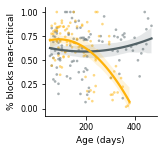

In [151]:
# Extract start day of each bin to use as the x-value
result['start_day'] = result['week_bin'].apply(lambda x: int(float(x.split('-')[0])))

# Filter data for 'wt' and 'te4'
wt_data = result[result['geno'] == 'wt'].sort_values(by='start_day')
te4_data = result[result['geno'] == 'te4'].sort_values(by='start_day')

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[2, 2])

# Plot scatter for 'wt' and 'te4'
ax.scatter(wt_data['start_day'], wt_data['proportion'], s=7, color=sns.xkcd_rgb['gunmetal'], alpha=0.5, edgecolor=[])
ax.scatter(te4_data['start_day'], te4_data['proportion'], s=7, color=sns.xkcd_rgb['saffron'], alpha=0.5, edgecolor=[])

# Regression plots
sns.regplot(data=wt_data, x='start_day', y='proportion', order=2, color=sns.xkcd_rgb['gunmetal'], scatter=False)
sns.regplot(data=te4_data, x='start_day', y='proportion', order=2, color=sns.xkcd_rgb['saffron'], scatter=False)

plt.xlabel('Age (days)', fontsize=9)
plt.ylabel('% blocks near-critical', fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

sns.despine()
plt.show()



In [152]:
def classify_age_group(start_day):
    if start_day < 91:
        return 'young'
    elif 91 <= start_day <= 274:
        return 'mid'
    else:
        return 'old'

result['age_group'] = result['start_day'].apply(classify_age_group)


In [153]:
result

,week_bin,geno,animal,proportion,start_day,age_group
151,50.0-56.0,te4,caf60,0.714286,50,young
152,50.0-56.0,wt,kdr27,0.545455,50,young
157,57.0-63.0,wt,caf101,0.833333,57,young
159,57.0-63.0,wt,kdr27,0.620253,57,young
158,57.0-63.0,wt,kdr14,0.444444,57,young
...,...,...,...,...,...,...
146,449.0-455.0,wt,caf81,0.821429,449,old
147,449.0-455.0,wt,caf82,0.666667,449,old
148,456.0-462.0,wt,caf81,0.933333,456,old
149,456.0-462.0,wt,caf82,NaN,456,old


In [155]:
result[result.age_group == 'old']

,week_bin,geno,animal,proportion,start_day,age_group
105,295.0-301.0,te4,caf79,0.689655,295,old
104,295.0-301.0,te4,caf78,0.666667,295,old
106,295.0-301.0,te4,caf80,0.750000,295,old
107,302.0-308.0,te4,caf78,0.142857,302,old
108,302.0-308.0,te4,caf80,0.315789,302,old
109,302.0-308.0,wt,caf108,0.318182,302,old
110,309.0-315.0,te4,caf78,0.145161,309,old
111,309.0-315.0,te4,caf80,0.087500,309,old
112,309.0-315.0,wt,caf108,0.600000,309,old
114,316.0-322.0,te4,caf80,0.166667,316,old


In [123]:
result.to_pickle(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_nearcrit_dataframe.pkl')
result.to_csv(f'/media/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_nearcrit_dataframe.csv')



In [124]:
result

,week_bin,geno,animal,proportion,start_day,age_group
151,50.0-56.0,te4,caf60,0.714286,50,young
152,50.0-56.0,wt,kdr27,0.545455,50,young
157,57.0-63.0,wt,caf101,0.833333,57,young
159,57.0-63.0,wt,kdr27,0.620253,57,young
158,57.0-63.0,wt,kdr14,0.444444,57,young
...,...,...,...,...,...,...
146,449.0-455.0,wt,caf81,0.821429,449,old
147,449.0-455.0,wt,caf82,0.666667,449,old
148,456.0-462.0,wt,caf81,0.933333,456,old
149,456.0-462.0,wt,caf82,NaN,456,old


In [158]:
dcc_df[dcc_df.animal == 'caf77'].age_days.unique()

array([398.04055556, 398.12388889, 398.37388889, 398.45722222,
       398.54055556, 398.62388889, 398.70722222, 403.31834491,
       403.40167824, 403.48501157, 403.56834491, 403.65167824,
       403.73501157, 403.81835648, 403.90168981, 403.98502315,
       404.06835648, 404.15168981, 404.23502315, 404.31835648,
       404.40168981, 404.48502315, 404.56835648, 404.65168981,
       404.73502315, 404.81835648, 404.90168981, 404.98502315,
       405.06835648, 405.15168981, 405.23502315, 405.31835648,
       405.40168981, 405.48502315, 405.56835648, 405.65168981,
       405.73502315, 411.4053588 , 411.48869213, 411.57202546,
       411.6553588 , 411.73869213, 411.82202546, 411.90537037,
       411.9887037 , 412.07203704, 412.15537037, 412.2387037 ,
       412.32203704, 414.40546296, 414.4887963 , 414.57212963,
       414.65546296, 414.7387963 , 414.82212963, 414.90546296,
       414.9887963 , 415.07212963, 415.15546296, 415.2387963 ,
       415.32212963, 421.25174769, 421.33508102, 421.41

In [125]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [140]:
%%R

# load LMER libraries
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
# load dataset in R
#fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/FR_by_SW_grouped_e4_wt.csv'

fn = '/media/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/2023-08-23_nearcrit_dataframe.csv'
nearcrit_data <- read_csv(file = fn)

nearcrit_data$start_day <- as.factor(nearcrit_data$start_day)


#fr_lmer = lmer(firing_rates ~ age_group * geno * state * cell_type  + (1|animal), data = filtered_data)
nearcrit_lmer = lmer(proportion ~ start_day * geno + (1|animal), data = nearcrit_data)


New names:
• `` -> `...1`
Rows: 213 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): week_bin, geno, animal, age_group
dbl (3): ...1, proportion, start_day

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed-effect model matrix is rank deficient so dropping 24 columns / coefficients


In [141]:
%%R 
# this will provide general information
summary(nearcrit_lmer)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: proportion ~ start_day * geno + (1 | animal)
   Data: nearcrit_data

REML criterion at convergence: 12.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9609 -0.3366  0.0000  0.3781  1.9609 

Random effects:
 Groups   Name        Variance Std.Dev.
 animal   (Intercept) 0.03574  0.1891  
 Residual             0.02616  0.1617  
Number of obs: 207, groups:  animal, 39

Fixed effects:
                      Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)          6.209e-01  1.877e-01  1.133e+02   3.308  0.00126 **
start_day57         -2.395e-02  1.932e-01  8.407e+01  -0.124  0.90167   
start_day64         -1.735e-02  1.932e-01  8.407e+01  -0.090  0.92868   
start_day71          1.529e-02  1.932e-01  8.407e+01   0.079  0.93713   
start_day78          1.600e-01  1.865e-01  8.548e+01   0.858  0.39336   
start_day85          2.743e-02  1.865e-01  8.548e+01   0.147  0.883


Correlation matrix not shown by default, as p = 92 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it



In [142]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(nearcrit_lmer)


Type III Analysis of Variance Table with Satterthwaite's method
                Sum Sq  Mean Sq NumDF  DenDF F value Pr(>F)
start_day      1.86835 0.032778    57 67.918  1.2528 0.1859
geno           0.01633 0.016325     1 22.028  0.6240 0.4380
start_day:geno 0.69289 0.020997    33 80.026  0.8025 0.7567


Missing cells for: start_day260:genote4, start_day274:genote4, start_day337:genote4, start_day358:genote4, start_day386:genote4, start_day393:genote4, start_day400:genote4, start_day407:genote4, start_day414:genote4, start_day421:genote4, start_day428:genote4, start_day435:genote4, start_day442:genote4, start_day449:genote4, start_day456:genote4, start_day470:genote4, start_day106:genowt, start_day225:genowt, start_day232:genowt, start_day239:genowt, start_day246:genowt, start_day295:genowt, start_day372:genowt, start_day379:genowt.  
Interpret type III hypotheses with care.


In [144]:
%%R
emmresults = emmeans(nearcrit_lmer, pairwise ~  geno | start_day, adjust = 'tukey')
print(emmresults)


$emmeans
start_day = 50:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.6209 0.1882 113.6  0.247949    0.994
 wt   0.4026 0.1899 110.5  0.026250    0.779

start_day = 57:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.5969 0.1213  97.1  0.356130    0.838
 wt   0.5147 0.1073 104.9  0.301985    0.727

start_day = 64:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.6035 0.1213  97.1  0.362730    0.844
 wt   0.4671 0.1073 104.9  0.254418    0.680

start_day = 71:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.6362 0.1213  97.1  0.395363    0.877
 wt   0.5050 0.1073 104.9  0.292346    0.718

start_day = 78:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.7809 0.1016  70.5  0.578251    0.984
 wt   0.5854 0.0839  85.5  0.418581    0.752

start_day = 85:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.6483 0.1016  70.5  0.445672    0.851
 wt   0.4334 0.0800  78.3  0.274014    0.593

start_day = 92:
 geno emmean     SE    df  lower.CL upper.CL
 te4  0.5725 0.101

In [132]:
%%R
emmresults = emmeans(nearcrit_lmer, pairwise ~  geno * age_group, adjust = 'tukey')
print(emmresults)


$emmeans
 geno age_group emmean     SE   df lower.CL upper.CL
 te4  mid        0.620 0.0696 29.6   0.4773    0.762
 wt   mid        0.649 0.0563 45.1   0.5353    0.762
 te4  old        0.275 0.0968 40.2   0.0794    0.471
 wt   old        0.632 0.0742 36.6   0.4811    0.782
 te4  young      0.666 0.0782 44.9   0.5084    0.823
 wt   young      0.502 0.0635 58.5   0.3746    0.629

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast             estimate     SE    df t.ratio p.value
 te4 mid - wt mid      -0.0290 0.0895  34.7  -0.324  0.9995
 te4 mid - te4 old      0.3445 0.1193  36.1   2.889  0.0659
 te4 mid - wt old      -0.0119 0.1018  33.1  -0.117  1.0000
 te4 mid - te4 young   -0.0462 0.0539 186.3  -0.859  0.9557
 te4 mid - wt young     0.1180 0.0942  39.4   1.253  0.8080
 wt mid - te4 old       0.3735 0.1120  41.4   3.335  0.0208
 wt mid - wt old        0.0170 0.0931  39.4   0.183  1.0000
 wt mid - te4 young    -0.0173 0.0963  45.0  -0.179  1.0

In [16]:
df

,level_0,index,animal,probe,date,time_frame,block_num,scored,bday,rstart_time,...,br1,br2,burst,T,num_cells,npy_file,region,age_days,phase,bin
0,0.0,0.0,caf72,probe1,032421,0_4,0,xgb,2020-11-24 07:30:00,2021-03-24 11:13:30,...,0.98917,0.990598,"[3, 1, 7, 6, 3, 2, 6, 4, 2, 1, 3, 1, 1, 2, 3, ...","[3, 1, 4, 4, 1, 1, 4, 3, 1, 1, 3, 1, 1, 1, 3, ...",5,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,120.155208,B,Mid
1,1.0,0.0,caf72,probe1,032421,12_16,1,xgb,2020-11-24 07:30:00,2021-03-24 23:13:34,...,0.984152,0.98215,"[7, 1, 3, 3, 2, 6, 2, 4, 1, 10, 3, 2, 1, 1, 1,...","[5, 1, 2, 2, 2, 4, 1, 3, 1, 5, 2, 2, 1, 1, 1, ...",6,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,120.738588,B,Mid
2,2.0,0.0,caf95,probe1,041921,156_158,0,xgb,2021-01-30 07:30:00,2021-04-26 03:01:32,...,0.861141,0.925759,"[3, 10, 13, 12, 8, 2, 11, 9, 1, 27, 4, 26, 5, ...","[2, 4, 4, 3, 2, 1, 3, 3, 1, 7, 3, 6, 2, 1, 7, ...",26,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,85.813565,B,Young
3,3.0,0.0,caf88,probe1,040221,88_92,0,xgb,2019-12-05 07:30:00,2021-04-06 05:07:39,...,0.994047,0.99331,"[1, 10, 4, 3, 6, 4, 8, 4, 13, 4, 4, 6, 4, 3, 4...","[1, 5, 2, 1, 3, 3, 2, 3, 5, 1, 1, 3, 2, 2, 1, ...",33,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,487.901146,C,Old
4,4.0,0.0,caf88,probe1,040221,88_92,1,xgb,2019-12-05 07:30:00,2021-04-06 05:07:39,...,0.995305,0.995259,"[2, 3, 8, 3, 2, 3, 3, 2, 3, 5, 1, 4, 5, 2, 2, ...","[1, 1, 5, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, ...",33,/scratch/khengen_lab/crit_sahara/DATA/media/Hl...,CA1,487.984479,C,Old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,caf102,probe1,052021,192_196,0,xgb,2021-01-30 07:30:00,2021-05-28 16:34:19,...,None,None,"[12, 1, 1, 1, 6, 2, 1, 8, 3, 4, 7, 5, 4, 2, 1,...","[7, 1, 1, 1, 2, 2, 1, 4, 2, 3, 3, 2, 2, 1, 1, ...",25,/media/HlabShare/Clustering_Data/CAF00102/caf1...,NaN,118.377998,NaN,Mid
0,NaN,NaN,caf102,probe1,052021,192_196,1,xgb,2021-01-30 07:30:00,2021-05-28 16:34:19,...,None,None,"[2, 1, 1, 1, 2, 1, 1, 1, 1, 6, 9, 5, 2, 1, 6, ...","[2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 3, 1, 1, 3, ...",25,/media/HlabShare/Clustering_Data/CAF00102/caf1...,NaN,118.461331,NaN,Mid
0,NaN,NaN,caf102,probe1,052021,196_200,0,xgb,2021-01-30 07:30:00,2021-05-28 20:34:19,...,None,None,"[36, 2, 7, 5, 2, 8, 6, 5, 21, 5, 30, 7, 2, 2, ...","[16, 1, 3, 2, 1, 4, 3, 4, 8, 3, 12, 3, 2, 1, 1...",19,/media/HlabShare/Clustering_Data/CAF00102/caf1...,NaN,118.544664,NaN,Mid
0,NaN,NaN,caf102,probe1,052021,196_200,1,xgb,2021-01-30 07:30:00,2021-05-28 20:34:19,...,None,None,"[4, 1, 5, 6, 1, 13, 4, 2, 2, 4, 3, 1, 2, 2, 4,...","[3, 1, 4, 5, 1, 10, 3, 2, 2, 2, 2, 1, 1, 2, 2,...",19,/media/HlabShare/Clustering_Data/CAF00102/caf1...,NaN,118.627998,NaN,Mid


In [29]:
print(len(df[(df.geno == 'te4') & (df.passed == True) & (df.dcc < 0.3) & (df.age_days > 334)])/len(df[(df.geno == 'te4') & (df.age_days > 334)]))
print('')

print(len(df[(df.geno != 'te4') & (df.passed == True) & (df.dcc < 0.3) & (df.age_days > 334)])/len(df[(df.geno != 'te4') & (df.age_days > 334)]))
print('')


0.09225092250922509

0.6171875



In [22]:
print(len(df[(df.geno == 'te4') & (df.passed == True) & (df.dcc < 0.3) & (df.age_days > 274)])/len(df[(df.geno == 'te4') & (df.age_days > 274)]))
print('')

tmpdf = []
tmpdf = df[(df.geno == 'te4') & (df.age_days > 274)]

perc_nearcrit_animal = []
for aa in tmpdf.animal.unique():
    print(aa)
    print(len(tmpdf[(tmpdf.animal == aa) & (tmpdf.passed == True)])/len(tmpdf[(tmpdf.animal == aa)]))
    perc_nearcrit_animal.append(len(tmpdf[(tmpdf.animal == aa) & (tmpdf.passed == True) & (tmpdf.dcc < 0.3)])/len(tmpdf[(tmpdf.animal == aa)]))

print('')
print(np.mean(perc_nearcrit_animal))
print(scipy.stats.sem(perc_nearcrit_animal))



0.22910662824207492

caf78
0.4111111111111111
caf79
0.7241379310344828
caf37
0.04195804195804196
caf62
0.018518518518518517
caf80
0.3686868686868687

0.2608836374353616
0.121546204210965


In [95]:
print(len(dcc_lmer[(dcc_lmer.geno == 'te4') & (dcc_lmer.passed == True) & (dcc_lmer.age_days > 274)])/len(dcc_lmer[(dcc_lmer.geno == 'te4') & (dcc_lmer.age_days > 274)]))

#print(len(dcc_df[(dcc_df.geno == 'te4') & (dcc_df.passed == True) & (dcc_df.age_days > 274)])/len(dcc_df[(dcc_df.geno == 'te4') & (dcc_df.age_days > 274)]))




0.3172932330827068


In [106]:
tmpdf = []
tmpdf = dcc_df[(dcc_df.geno == 'te4') & (dcc_df.age_days > 274)]

perc_passed_animal = []
for aa in tmpdf.animal.unique():
    print(aa)
    print(len(tmpdf[(tmpdf.animal == aa) & (tmpdf.passed == True)])/len(tmpdf[(tmpdf.animal == aa)]))
    perc_passed_animal.append(len(tmpdf[(tmpdf.animal == aa) & (tmpdf.passed == True)])/len(tmpdf[(tmpdf.animal == aa)]))



caf78
0.4111111111111111
caf80
0.3686868686868687
caf79
0.7241379310344828
caf62
0.018518518518518517
caf37
0.04195804195804196


In [107]:
print(np.mean(perc_passed_animal))
print(scipy.stats.sem(perc_passed_animal))


0.3128824942618046
0.13075630629527482


In [108]:
tmpdf = []
tmpdf = dcc_df[(dcc_df.geno != 'te4') & (dcc_df.age_days > 274)]

perc_passed_animal = []
for aa in tmpdf.animal.unique():
    print(aa)
    print(len(tmpdf[(tmpdf.animal == aa) & (tmpdf.passed == True)])/len(tmpdf[(tmpdf.animal == aa)]))
    perc_passed_animal.append(len(tmpdf[(tmpdf.animal == aa) & (tmpdf.passed == True)])/len(tmpdf[(tmpdf.animal == aa)]))



caf89
0.9545454545454546
caf108
0.6797752808988764
caf109
0.4228187919463087
caf61
0.7769784172661871
caf69
0.7777777777777778
caf104
0.7230769230769231
caf77
0.5616438356164384
caf81
0.8770491803278688
caf82
0.6
caf88
0.3783783783783784


In [109]:
print(np.mean(perc_passed_animal))
print(scipy.stats.sem(perc_passed_animal))


0.6752044039834212
0.05890864356160866


In [15]:
SAVEFIGS = 0

In [16]:
len(tmpanimalwt[(tmpanimalwt.passed == True) & (tmpanimalwt.dcc < 0.1)])/len(tmpanimalwt)

0.3225806451612903

In [17]:
wtpassed

[0.46153846153846156,
 0.5503875968992248,
 0.5390070921985816,
 0.4251497005988024,
 0.47635135135135137,
 0.364,
 0.5588235294117647,
 0.6329113924050633,
 nan,
 0.7571428571428571,
 1.0,
 0.7647058823529411,
 0.42857142857142855,
 0.7051282051282052,
 0.5185185185185185,
 0.6785714285714286,
 0.4925373134328358,
 0.3763440860215054,
 0.15151515151515152,
 0.3,
 0.5664335664335665,
 0.5203252032520326,
 0.4873096446700508,
 0.34615384615384615,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7027027027027027,
 0.75,
 0.6933333333333334,
 0.9545454545454546,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.7777777777777778,
 nan,
 nan,
 nan,
 0.64,
 0.4090909090909091,
 0.7333333333333333,
 0.6666666666666666,
 0.5,
 0.3333333333333333,
 0.5714285714285714,
 0.6153846153846154,
 1.0,
 0.7837837837837838,
 0.9032258064516129,
 nan,
 0.8571428571428571,
 nan,
 0.43548387096774194,
 nan,
 nan,
 nan,
 nan,
 nan]

# Analyze DCC by sleep/wake state:

In [18]:
SW = pd.read_pickle(f'/{basedir}/HlabShare/james/SW_array_FINAL.pkl')


In [19]:
state_dense_threshold = 0.66

SW_DCC = pd.DataFrame()

tmp_dcc_df = df[df.dcc < 1]

df_SW_tmp = SW
df_SW_tmp = df_SW_tmp.replace('E4', 'WT')

for ii in np.arange(0,len(df_SW_tmp)):

    which_day = ii
    wake_dense_FRs_thisanimal = []
    sleep_dense_FRs_thisanimal = []
    wake_dense_celltypes_thisanimal = []

    startpt = df_SW_tmp.iloc[which_day]['Age']
    endpt = df_SW_tmp.iloc[which_day]['Age'] + len(df_SW_tmp.iloc[which_day]['SW Array'])*4/3600/24
    
    thisdaydf = []
    thisdaydf = tmp_dcc_df[(tmp_dcc_df.animal == df_SW_tmp.iloc[which_day]['Animal'].lower()) & (tmp_dcc_df.age_days > startpt) & 
                     (tmp_dcc_df.age_days < endpt)]


    two_hr_bins = np.arange(0/24,(endpt - startpt),2/24)
    for b in np.arange(0,len(two_hr_bins)):
        tmpdf = []
        tmpdf = thisdaydf[(thisdaydf.age_days > startpt + two_hr_bins[b]) & (thisdaydf.age_days < startpt + two_hr_bins[b] + 2/24)]

        if len(tmpdf) > 0:
            tmp_states = []
            tmp_states = df_SW_tmp.iloc[which_day]['SW Array'][1800*b:1800*(b+1)]

            tmp_percwake = []
            #tmp_percwake = len(tmp_states[np.logical_or(tmp_states == 1, tmp_states == 4, tmp_states == 5)])/len(tmp_states)
            tmp_percwake = len(tmp_states[(tmp_states == 1)])/len(tmp_states)
            tmp_percsleep = len(tmp_states[np.logical_or(tmp_states == 2, tmp_states == 3)])/len(tmp_states)
            tmp_percNREM = len(tmp_states[(tmp_states == 2)])/len(tmp_states)
            tmp_percREM = len(tmp_states[(tmp_states == 3)])/len(tmp_states)

            tmpdf.loc[:,'percent_wake']= [tmp_percwake]*len(tmpdf)
            tmpdf.loc[:,'percent_sleep']= [tmp_percsleep]*len(tmpdf)
            tmpdf.loc[:,'percent_NREM']= [tmp_percNREM]*len(tmpdf)
            tmpdf.loc[:,'percent_REM']= [tmp_percREM]*len(tmpdf)
            
            if tmp_percwake > state_dense_threshold:
                tmpdf.loc[:,'state_density']= ['wake_dense']*len(tmpdf)
            elif tmp_percsleep > state_dense_threshold:
                tmpdf.loc[:,'state_density']= ['sleep_dense']*len(tmpdf)
            else:
                 tmpdf.loc[:,'state_density']= ['medium']*len(tmpdf)


        SW_DCC = pd.concat([SW_DCC, tmpdf])
        
#SW_FR['state_density'] = pd.cut(x = SW_FR['percent_wake'], bins=[0, .3, .66, 1], 
#                              labels = ['sleep_dense','middle','wake_dense'])
                              
SW_DCC = SW_DCC.replace('E4', 'WT')
SW_DCC = SW_DCC.replace('e4', 'wt')



/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x
/hlabhome/wg-mjames/tmp/x3uS/ipykernel_48905/3452891366.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmpdf.loc[:,'percent_wake']= [tmp_percwake]*len(tmpdf)
/hlabhome/wg-mjames/tmp/x3uS/ipykernel_48905/3452891366.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

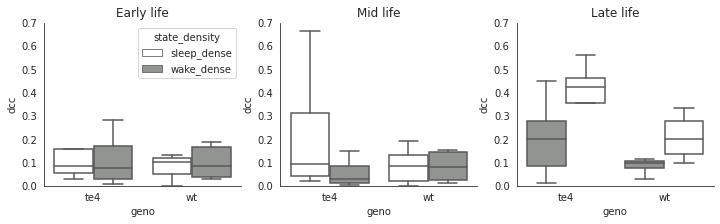

In [117]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(1, 3, figsize=[12,3])

col_palette = {'wake_dense': sns.xkcd_rgb['grey'], 'sleep_dense': sns.xkcd_rgb['white']}

plotting_SW_DCC = SW_DCC[(SW_DCC.state_density != 'medium') & (SW_DCC.age_days < 91)]
sns.boxplot(data=plotting_SW_DCC, x="geno", y="dcc", hue="state_density", palette = col_palette, showfliers = False, ax=ax[0])
#ax[0].get_legend().remove()
ax[0].set_ylim([0,.7])
ax[0].set_title('Early life')

plotting_SW_DCC = SW_DCC[(SW_DCC.state_density != 'medium') & (SW_DCC.age_days > 91) & (SW_DCC.age_days < 274)]
sns.boxplot(data=plotting_SW_DCC, x="geno", y="dcc", hue="state_density", palette = col_palette, showfliers = False, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set_ylim([0,.7])
ax[1].set_title('Mid life')

plotting_SW_DCC = SW_DCC[(SW_DCC.state_density != 'medium') & (SW_DCC.age_days > 274)]
sns.boxplot(data=plotting_SW_DCC, x="geno", y="dcc", hue="state_density", palette = col_palette, showfliers = False, ax=ax[2])
ax[2].get_legend().remove()
ax[2].set_ylim([0,.7])  
ax[2].set_title('Late life')


sns.despine()





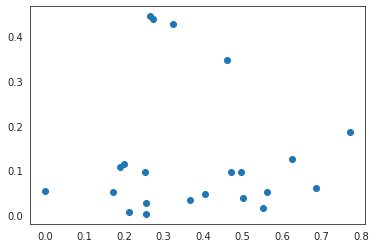

In [125]:
plt.scatter(SW_DCC[SW_DCC.animal == 'kdr27'].percent_wake, SW_DCC[SW_DCC.animal == 'kdr27'].dcc)




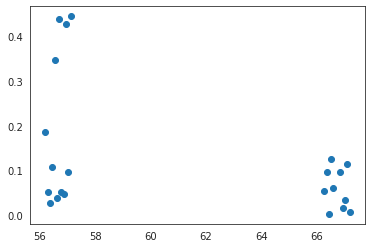

In [119]:
plt.scatter(SW_DCC[SW_DCC.animal == 'kdr27'].age_days, SW_DCC[SW_DCC.animal == 'kdr27'].dcc)




IndexError: index 9 is out of bounds for axis 0 with size 3

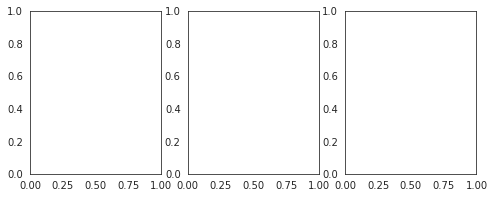

In [25]:
col_palette = {'wake_dense': sns.xkcd_rgb['black'], 'sleep_dense': sns.xkcd_rgb['white']}

def run_stats_on_statedense(tmp_stats_SW):
    wake_stats = []
    sleep_stats = []
    wake_stats = np.array(tmp_stats_SW[(tmp_stats_SW.state_density == 'wake_dense') 
                                         & (tmp_stats_SW.cv_geno == 'te4')].cv)
    sleep_stats = np.array(tmp_stats_SW[(tmp_stats_SW.state_density == 'sleep_dense') 
                                         & (tmp_stats_SW.cv_geno == 'te4')].cv)
    print(f'TE4 p = {str(scipy.stats.ttest_ind(wake_stats, sleep_stats)[1])}')
    wake_stats = []
    sleep_stats = []
    wake_stats = np.array(tmp_stats_SW[(tmp_stats_SW.state_density == 'wake_dense') 
                                         & (tmp_stats_SW.cv_geno == 'wt')].cv)
    sleep_stats = np.array(tmp_stats_SW[(tmp_stats_SW.state_density == 'sleep_dense') 
                                         & (tmp_stats_SW.cv_geno == 'wt')].cv)
    print(f'WT p = {str(scipy.stats.ttest_ind(wake_stats, sleep_stats)[1])}')
    

def make_violin_plots(tmp_SW_df, col_palette, axcoord):
    
    #run_stats_on_statedense(tmp_SW_df)
    
    sns.violinplot(data = tmp_SW_df, x = 'geno', y = 'dcc', cut=2, hue= 'state_density', 
                   palette = col_palette, split=True, ax=ax[axcoord], inner="quartile")
    if axcoord == 0:
        plt.legend(fontsize=9)
    else:
        ax[axcoord].get_legend().remove()
    for ind, violin in enumerate(ax[axcoord].findobj(PolyCollection)):
        if ind == 0:
            violin.set_facecolor(sns.xkcd_rgb['saffron'])
            violin.set_edgecolor(sns.xkcd_rgb['saffron'])
        elif ind == 1:
            violin.set_facecolor(sns.xkcd_rgb['white'])
            violin.set_edgecolor(sns.xkcd_rgb['saffron'])
        elif ind == 2:
            violin.set_facecolor(sns.xkcd_rgb['gunmetal'])
            violin.set_edgecolor(sns.xkcd_rgb['gunmetal'])
        elif ind == 3:
            violin.set_facecolor(sns.xkcd_rgb['white'])
            violin.set_edgecolor(sns.xkcd_rgb['gunmetal'])
        
fig, ax = plt.subplots(1, 3, figsize=[8,3])

plotting_SW_FR = SW_DCC[(SW_DCC.state_density != 'medium')]
make_violin_plots(plotting_SW_FR, col_palette, i)

# for i,j in enumerate(plotting_SW_FR.bins.unique()):
#     tmp_SW_df = plotting_SW_FR[(plotting_SW_FR.bins == j)]
#     make_violin_plots(tmp_SW_df, col_palette, i)
# ax[0].title.set_text('Early life, all neurons')
# ax[1].title.set_text('Mid life, all neurons')
# ax[2].title.set_text('Late life, all neurons')
# sns.despine()



# Generate additional avalanche distribution plots:

# Starting with WT:

Data has 29 neurons with length 180000*binsize
perc_threshold  4
Time took in get_avalanches is 0.12896227836608887 seconds
Data has 29 neurons with length 180000*binsize
perc_threshold  4
Time took in get_avalanches is 0.16008710861206055 seconds


/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/hlabhome/wg-mjames/tmp/yXgq/ipykernel_18455/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


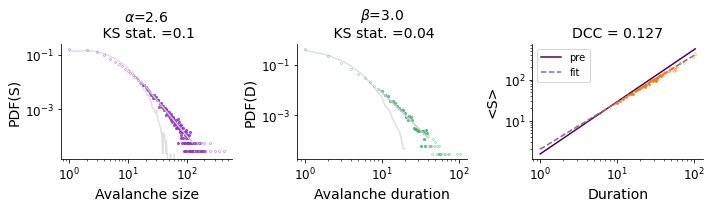

In [3]:
whichanimal = 'kdr36'
whichblock = 4

neurons = np.load(f'/{basedir}/HlabShare/Clustering_Data/KDR00036/kdr36_01222022/12_16/probe1/co/H_2022-01-23_02-36-52_2022-01-23_06-31-52_neurons_group0.npy', allow_pickle=True)

good_cells = []
for a in neurons:
    if a.quality < 3:
        good_cells.append(a)
        
start_hr = 2
end_hr = start_hr+2

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r = cr.get_avalanches(spkwords, .35)
S = r['S']
T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']


#S = df[df.animal == whichanimal].iloc[whichblock]['burst']
#T = df[df.animal == whichanimal].iloc[whichblock]['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)

#fig1 = scaling_plots(Result, burst, burstMin, burstMax, alpha, T,
#                             tMin, tMax, beta, TT, Sm, sigma, fit_sigma,
#                             pltname, saveloc, Result['P_burst'], Result['P_t'], burst_shuff, T_shuff)

#Make plots of the distributions and scaling relation (DCC)

plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')

analysisResults['scaling_relation_plot']


Data has 32 neurons with length 180000*binsize
perc_threshold  5
Time took in get_avalanches is 0.12357091903686523 seconds
Data has 32 neurons with length 180000*binsize
perc_threshold  6
Time took in get_avalanches is 0.16651606559753418 seconds


/hlabhome/wg-mjames/tmp/yXgq/ipykernel_18455/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),


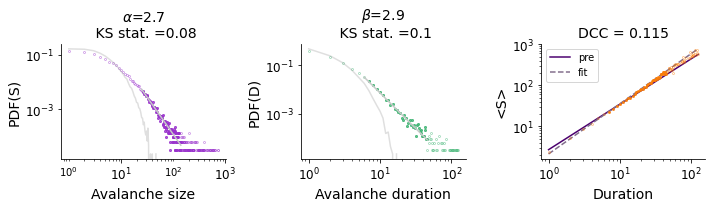

In [4]:
whichanimal = 'kdr27'
whichblock = 12

neurons = np.load(f'/{basedir}//HlabShare/Clustering_Data/KDR00027/kdr27_01202022/0_4/probe1/co/H_2022-01-20_11-07-13_2022-01-20_15-02-14_neurons_group0.npy', allow_pickle=True)

good_cells = []
for a in neurons:
    if a.quality < 3:
        good_cells.append(a)
        
start_hr = 0
end_hr = start_hr+2

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r = cr.get_avalanches(spkwords, .35)
S = r['S']
T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']


#S = df[df.animal == whichanimal].iloc[whichblock]['burst']
#T = df[df.animal == whichanimal].iloc[whichblock]['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)

#fig1 = scaling_plots(Result, burst, burstMin, burstMax, alpha, T,
#                             tMin, tMax, beta, TT, Sm, sigma, fit_sigma,
#                             pltname, saveloc, Result['P_burst'], Result['P_t'], burst_shuff, T_shuff)

#Make plots of the distributions and scaling relation (DCC)

plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')
    

analysisResults['scaling_relation_plot']

# And now old TE4:

Data has 23 neurons with length 180000*binsize
perc_threshold  2
Time took in get_avalanches is 0.0977015495300293 seconds
Data has 23 neurons with length 180000*binsize
perc_threshold  4
Time took in get_avalanches is 0.1501917839050293 seconds


/hlabhome/wg-mjames/tmp/yXgq/ipykernel_18455/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),


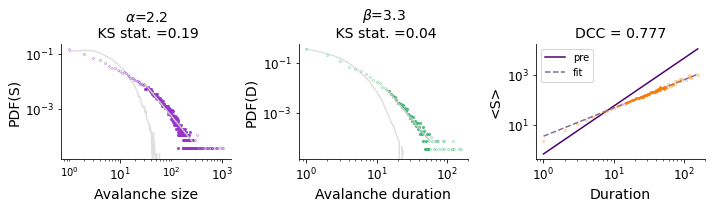

In [5]:
whichanimal = 'caf78'
whichblock = 12

neurons = np.load(f'/{basedir}//HlabShare/Clustering_Data/CAF00078/03122021/0_4/probe1/co/H_2021-03-12_11-54-22_2021-03-12_15-49-23_neurons_group0.npy', allow_pickle=True)

good_cells = []
for a in neurons:
    if a.quality < 3:
        good_cells.append(a)
        
start_hr = 0
end_hr = start_hr+2

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r = cr.get_avalanches(spkwords, .35)
S = r['S']
T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']


#S = df[df.animal == whichanimal].iloc[whichblock]['burst']
#T = df[df.animal == whichanimal].iloc[whichblock]['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)

#fig1 = scaling_plots(Result, burst, burstMin, burstMax, alpha, T,
#                             tMin, tMax, beta, TT, Sm, sigma, fit_sigma,
#                             pltname, saveloc, Result['P_burst'], Result['P_t'], burst_shuff, T_shuff)

#Make plots of the distributions and scaling relation (DCC)

plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')

analysisResults['scaling_relation_plot']

Data has 134 neurons with length 180000*binsize
perc_threshold  15
Time took in get_avalanches is 0.14332103729248047 seconds
Data has 134 neurons with length 180000*binsize
perc_threshold  18
Time took in get_avalanches is 0.175933837890625 seconds


/hlabhome/wg-mjames/tmp/yXgq/ipykernel_18455/1307218390.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1[2].plot(TT, (np.power(TT, fit_sigma[0]) / np.power(TT[7], fit_sigma[0]) * Sm[7]),


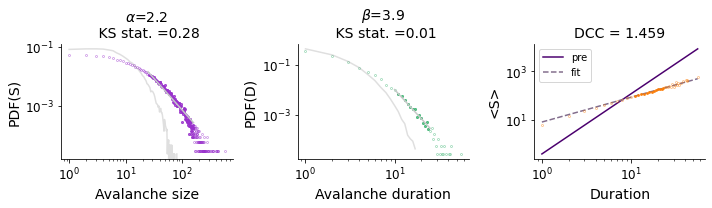

In [6]:
whichanimal = 'caf62'
whichblock = 12

neurons = np.load(f'/{basedir}//HlabShare/Clustering_Data/CAF00062/caf62_11182020/0_12/probe1/co/H_2020-11-18_16-14-24_2020-11-19_04-09-25_neurons_group0_scored_clayton.npy', allow_pickle=True)

good_cells = []
for a in neurons:
    if a.quality < 3:
        good_cells.append(a)
        
start_hr = 4
end_hr = start_hr+2

real_data = []
shuff_data = []

for a in good_cells:
    tmpspiketimes = []
    tmpspiketimes = a.spike_time_sec[a.spike_time_sec > (3600*start_hr)]
    tmpspiketimes = tmpspiketimes[tmpspiketimes < (3600*end_hr)]
    
    real_data.append(tmpspiketimes)
    
    spikes_shuffle = []
    spikes_shuffle = np.sort(np.random.random(size = len(tmpspiketimes))*(2*3600) + np.min(tmpspiketimes))
    shuff_data.append(spikes_shuffle)
    

#spikewords = mbt.n_spiketimes_to_spikewords(real_data, binsz = 0.04, binarize = 1)

spkwords = spiketimes_to_spikewords(real_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r = cr.get_avalanches(spkwords, .35)
S = r['S']
T = r['T']

spkwords_shuff = spiketimes_to_spikewords(shuff_data,3600*start_hr,3600*end_hr,40,1) # 1 for binary
r_shuff = cr.get_avalanches(spkwords_shuff, .35)
S_shuff = r_shuff['S']
T_shuff = r_shuff['T']


#S = df[df.animal == whichanimal].iloc[whichblock]['burst']
#T = df[df.animal == whichanimal].iloc[whichblock]['T']

theseparams = saw.get_params(whichanimal,'CA1',flag=3)

params = {
    'flag': 1, #whet
    'bm': theseparams['bm'],
    'tm': theseparams['tm'], 
    'nfactor_bm': theseparams['nfactor_bm'], 
    'nfactor_tm': theseparams['nfactor_tm'], 
    'nfactor_bm_tail': theseparams['nfactor_bm_tail'],
    'nfactor_tm_tail': theseparams['nfactor_tm_tail'], 
    'none_fact': 20, 
    'max_time':9000, 
    'plot': True,
    'pltname': 'plotDCC',
    'saveloc': '/media/HlabShare/james'
}

analysisResults = AV_analysis(S, T, S_shuff, T_shuff, flag = 1, bm = params['bm'], 
                                  tm = params['tm'], plot = params['plot'], nfactor_bm = params['nfactor_bm'], 
                                  nfactor_tm = params['nfactor_tm'], nfactor_bm_tail = params['nfactor_bm_tail'], 
                                  nfactor_tm_tail = params['nfactor_tm_tail'], none_fact = params['none_fact'], 
                                  max_time = params['max_time'], verbose=False)

#fig1 = scaling_plots(Result, burst, burstMin, burstMax, alpha, T,
#                             tMin, tMax, beta, TT, Sm, sigma, fit_sigma,
#                             pltname, saveloc, Result['P_burst'], Result['P_t'], burst_shuff, T_shuff)

#Make plots of the distributions and scaling relation (DCC)

plttitle = []
plttitle = f'{whichanimal}_block_num_{str(whichblock)}'
savename = []
savename = f'{whichanimal}_block_num_{str(whichblock)}'
#analysisResults['scaling_relation_plot'].suptitle(plttitle, x=0.5, y=1.05, fontsize=12)
analysisResults['scaling_relation_plot']

if SAVEFIGS:
    analysisResults['scaling_relation_plot'].savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_{savename}.pdf')

analysisResults['scaling_relation_plot']

# Supplemental:

# Make LMER p value results plots:

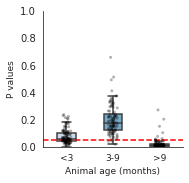

In [23]:
# Show linear mixed effects bootstrap p values for 100 comparisons of WT to TE4 at each of the 3 age ranges
fig, ax = plt.subplots(figsize=[2.5, 2.5])

fr_young = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_03172023_DCC_young.csv')
fr_mid = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_03172023_DCC_mid.csv')
fr_old = pd.read_csv(f'/{basedir}/HlabShare/james/LMER_loop_03172023_DCC_old.csv')

dcc_young = fr_young
dcc_mid = fr_mid
dcc_old = fr_old

tempdf = pd.DataFrame()
ps = np.concatenate([np.array(fr_young.x), np.array(fr_mid.x), np.array(fr_old.x)])
xs = np.concatenate([np.ones(len(fr_young.x))*0, np.ones(len(fr_mid.x))*.5, np.ones(len(fr_old.x))*1])
data = {'Xvals': xs,
        'Data': ps}
tempdf = pd.DataFrame(data) 


sns.stripplot(data=tempdf, x="Xvals", y="Data", size=3, color = 'black', alpha=0.3)
sns.boxplot(data=tempdf, x="Xvals", y="Data", width = 0.4, palette = 'Blues', showfliers=False)

plt.hlines(0.05, -0.5, 2.5, linestyle='--', color='red')

plt.xticks(ticks= [0,1,2],labels=['<3','3-9','>9'], fontsize=9)
plt.yticks(ticks= np.arange(0,1.1,.2), fontsize=10)
plt.xlabel('Animal age (months)', fontsize=9)
plt.ylabel('P values', fontsize=9)
plt.xlim(-0.5,2.5)
plt.ylim(0, 1.0)

#plt.gcf().subplots_adjust(left=0.2)

sns.despine(ax=ax)

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/{today}_DCC_LMER_pvals.pdf')




In [54]:
print(len(np.where(dcc_young < .05)[0]))
print(len(np.where(dcc_mid < .05)[0]))
print(len(np.where(dcc_old < .05)[0]))

42
3
92


# Make the boxenplot for DCC values, just passed blocks:

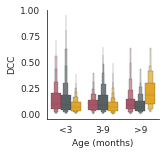

In [21]:
boxen_df = []
boxen_df = df.sort_values(by='animal')
boxen_df = boxen_df[boxen_df.passed == True]
bins = [0, 91, 274, 540]
boxen_df['bin'] = pd.cut(boxen_df['age_days'], bins)

plt.figure(figsize=[2,2])
col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

ax = sns.boxenplot(x = 'bin', y = 'dcc', hue = 'geno', showfliers=False, palette = col_palette, data=boxen_df, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('DCC', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_boxen_DCCs_justpassed.pdf')
    
    

# Make the boxenplot for DCC values, all blocks:

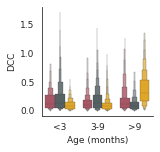

In [22]:
boxen_df = []
boxen_df = df.sort_values(by='animal')
#boxen_df = boxen_df[boxen_df.passed == True]
bins = [0, 91, 274, 540]
boxen_df['bin'] = pd.cut(boxen_df['age_days'], bins)

plt.figure(figsize=[2,2])
col_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'], sns.xkcd_rgb['saffron']]

ax = sns.boxenplot(x = 'bin', y = 'dcc', hue = 'geno', showfliers=False, palette = col_palette, data=boxen_df, linewidth = 0.25)

plt.xticks([0,1,2],['<3','3-9','>9'], fontsize=9)
plt.xlabel('Age (months)', fontsize=9)
plt.yticks(fontsize=9)
plt.ylabel('DCC', fontsize=9)
ax.get_legend().remove()

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_boxen_DCCs_allblocks.pdf')
    
    

# Run hierarchical bootstrap test on DCC data:

0.04083612040133779
0.14192222222222214
0.9978002244668913


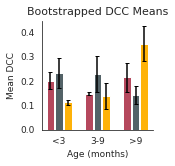

In [23]:
# Run James's heirarchical bootstrap for DCC

from random import choices

bins = [0, 91, 274, 700]

wt_mean = []
wt_sem = []
te4_mean = []
te4_sem = []
e4_mean = []
e4_sem = []
num_wts = []
num_te4s = []
num_e4s = []

for h in np.arange(0,len(bins)-1):
    
    try:

        thisdf = []
        thisdf = df[df.age_days > bins[h]]
        thisdf = thisdf[thisdf.age_days < bins[h+1]]

        animal_array_temp = thisdf.animal.unique()

        wt_temp = []
        te4_temp = []
        e4_temp = []

        for a in animal_array_temp:
            temparray = []
            temparray = thisdf[thisdf.animal == a]

            if temparray.geno.unique()[0] == 'wt':
                wt_temp.append(np.asarray(temparray.dcc))
            elif temparray.geno.unique()[0] == 'te4':
                te4_temp.append(np.asarray(temparray.dcc))
            elif temparray.geno.unique()[0] == 'e4':
                e4_temp.append(np.asarray(temparray.dcc))


        num_wts.append(len(wt_temp))
        num_te4s.append(len(te4_temp))
        num_e4s.append(len(e4_temp))

        nboot = 10000 

        bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
        for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
            temp = []
            temp = wt_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

        bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
        for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
            temp = []
            temp = te4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]


        bootstrapping_matrix3 = np.zeros([nboot,1,len(e4_temp)])
        for a in np.arange(0,len(e4_temp)): #loop thru number of e4 animals
            temp = []
            temp = e4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix3[n,0,a] = choices(temp, k=1)[0]


        nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
        bootstats1 = np.zeros([nboot2,1])
        bootstats2 = np.zeros([nboot2,1])
        bootstats3 = np.zeros([nboot2,1])

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats1[n] = np.nanmean(tempdata)


        for n in np.arange(0,nboot2):
            temp_animals =[]
            temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats2[n] = np.nanmean(tempdata)

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(e4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix3[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats3[n] = np.nanmean(tempdata)

        bootstats1 = bootstats1.flatten()
        bootstats2 = bootstats2.flatten()
        bootstats3 = bootstats3.flatten()

        wt_mean.append(np.nanmean(bootstats1))
        wt_sem.append(np.nanstd(bootstats1))
        te4_mean.append(np.nanmean(bootstats2))
        te4_sem.append(np.nanstd(bootstats2))
        e4_mean.append(np.nanmean(bootstats3))
        e4_sem.append(np.nanstd(bootstats3))

        sample1 = bootstats1
        sample2 = bootstats2

        joint_low_val = np.min([np.min(sample1), np.min(sample2)])
        joint_high_val = np.max([np.max(sample1), np.max(sample2)])

        p_joint_matrix = np.zeros([100,100])

        p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
        edge_shift = (p_axis[1] - p_axis[0])/2 
        p_axis_edges = p_axis - edge_shift
        p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

        def histc(X, bins):
            map_to_bins = np.digitize(X,bins)
            r = np.zeros(bins.shape)
            for i in map_to_bins:
                r[i-1] += 1
            return [r, map_to_bins]

        p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
        p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


        for i in np.arange(0, np.shape(p_joint_matrix)[0]):
            for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

        #p_joint_matrix
        p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
        p_test = sum(sum(np.triu(p_joint_matrix)));

        print(p_test)
        
    except:

        print(f'issue with loop number {a}')
        
# Make the heirarchical bootstrap figure
fig, ax = plt.subplots(1,figsize = (2,2))

color_palette = [sns.xkcd_rgb['dark rose'], sns.xkcd_rgb['gunmetal'],sns.xkcd_rgb['saffron']]

ax.bar([0,.9,1.8], [e4_mean[0], wt_mean[0], te4_mean[0]], yerr=[e4_sem[0], wt_sem[0], te4_sem[0]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([4,4.9,5.8], [e4_mean[1], wt_mean[1], te4_mean[1]], yerr=[e4_sem[1], wt_sem[1], te4_sem[1]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([8,8.9,9.8], [e4_mean[2], wt_mean[2], te4_mean[2]], yerr=[e4_sem[2], wt_sem[2], te4_sem[2]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.set_ylabel('Mean DCC', fontsize = 9)
plt.yticks(fontsize = 9)
ax.set_xticks([.9,4.9,8.9],['<3','3-9','>9'], fontsize = 9)
ax.set_xlabel('Age (months)', fontsize = 9)

plt.title('Bootstrapped DCC Means', fontsize=11)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/UPDATED_Fig4_figures/{today}_DCC_bootstapped_means.pdf')



In [57]:
dcc_lmer.geno.unique()

array(['te4', 'wt'], dtype=object)

In [13]:
df_ = df
df_ = df_[df_.dcc < 1]
df_ = df_.replace('e4','wt')
df_ = df_.sort_values(by=['geno'])
dcc_lmer = df_


# Define a function to categorize age
def categorize_age(age):
    if age < 91:
        return 'young'
    elif 91 <= age <= 274:
        return 'mid'
    else:
        return 'old'

# Apply the function to the age column to create the age_group column
dcc_lmer['age_group'] = dcc_lmer['age_days'].apply(categorize_age)



# Run James's heirarchical bootstrap for DCC

from random import choices

bins = [0, 91, 274, 700]

wt_mean = []
wt_sem = []
te4_mean = []
te4_sem = []
e4_mean = []
e4_sem = []
num_wts = []
num_te4s = []
num_e4s = []
p_tests = []

for h in np.arange(0,len(bins)-1):
    
    try:

        thisdf = []
        thisdf = dcc_lmer[dcc_lmer.age_days > bins[h]]
        thisdf = thisdf[thisdf.age_days < bins[h+1]]

        animal_array_temp = thisdf.animal.unique()

        wt_temp = []
        te4_temp = []

        for a in animal_array_temp:
            temparray = []
            temparray = thisdf[thisdf.animal == a]

            if temparray.geno.unique()[0] == 'wt':
                wt_temp.append(np.asarray(temparray.dcc))
            elif temparray.geno.unique()[0] == 'te4':
                te4_temp.append(np.asarray(temparray.dcc))

        num_wts.append(len(wt_temp))
        num_te4s.append(len(te4_temp))

        nboot = 10000 

        bootstrapping_matrix1 = np.zeros([nboot,1,len(wt_temp)])
        for a in np.arange(0,len(wt_temp)): #loop thru number of te4 animals
            temp = []
            temp = wt_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix1[n,0,a] = choices(temp, k=1)[0]

        bootstrapping_matrix2 = np.zeros([nboot,1,len(te4_temp)])
        for a in np.arange(0,len(te4_temp)): #loop thru number of te4 animals
            temp = []
            temp = te4_temp[a]
            for n in np.arange(0,nboot):
                bootstrapping_matrix2[n,0,a] = choices(temp, k=1)[0]



        nboot2 = 300 #Only repeating 300 times since the actual variance is in the previous step.
        bootstats1 = np.zeros([nboot2,1])
        bootstats2 = np.zeros([nboot2,1])

        for n in np.arange(0,nboot2):
            temp_animals = []
            temp_animals = choices(np.arange(0,len(wt_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix1[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats1[n] = np.nanmean(tempdata)


        for n in np.arange(0,nboot2):
            temp_animals =[]
            temp_animals = choices(np.arange(0,len(te4_temp)), k=3)

            tempdata = []
            for t in np.arange(0,len(temp_animals)):

                temp_pulls = choices(np.arange(0,nboot), k=nboot)
                tempdata.append(bootstrapping_matrix2[temp_pulls,:,temp_animals[t]])
                #temp_data = vertcat(temp_data,bootstrapping_matrix1(temp_pulls,:,temp_UL_birds(t))); 
                #tempdata = np.vstack(tempdata, bootstrapping_matrix1[temp_pulls,:,temp_UL_birds[t]])

            #wt_boot_means.append(np.nanmean(tempdata))
            bootstats2[n] = np.nanmean(tempdata)


        bootstats1 = bootstats1.flatten()
        bootstats2 = bootstats2.flatten()

        wt_mean.append(np.nanmean(bootstats1))
        wt_sem.append(np.nanstd(bootstats1))
        te4_mean.append(np.nanmean(bootstats2))
        te4_sem.append(np.nanstd(bootstats2))

        sample1 = bootstats1
        sample2 = bootstats2

        joint_low_val = np.min([np.min(sample1), np.min(sample2)])
        joint_high_val = np.max([np.max(sample1), np.max(sample2)])

        p_joint_matrix = np.zeros([100,100])

        p_axis = np.arange(joint_low_val, joint_high_val, (joint_high_val - joint_low_val)/100)
        edge_shift = (p_axis[1] - p_axis[0])/2 
        p_axis_edges = p_axis - edge_shift
        p_axis_edges = np.append(p_axis_edges, joint_high_val + edge_shift)

        def histc(X, bins):
            map_to_bins = np.digitize(X,bins)
            r = np.zeros(bins.shape)
            for i in map_to_bins:
                r[i-1] += 1
            return [r, map_to_bins]

        p_sample1 = histc(sample1,p_axis_edges)[0]/len(sample1)
        p_sample2 = histc(sample2,p_axis_edges)[0]/len(sample2)


        for i in np.arange(0, np.shape(p_joint_matrix)[0]):
            for j in np.arange(0,np.shape(p_joint_matrix)[1]):
                p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]

        #p_joint_matrix
        p_joint_matrix = p_joint_matrix/sum(sum(p_joint_matrix))
        p_test = sum(sum(np.triu(p_joint_matrix)));

        print(p_test)
        
        p_tests.append(p_test)
        
    except:

        print(f'issue with loop number {a}')
        
        
    

/hlabhome/wg-mjames/.conda/envs/james_test/lib/python3.8/site-packages/pandas/core/missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


0.037477777777777777
0.16801111111111108
0.990822222222222


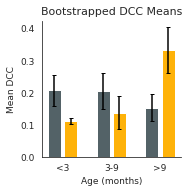

In [21]:
# Make the heirarchical bootstrap figure
fig, ax = plt.subplots(1,figsize = (2.5,2.5))

color_palette = [sns.xkcd_rgb['gunmetal'],sns.xkcd_rgb['saffron']]

ax.bar([0,1], [wt_mean[0], te4_mean[0]], yerr=[wt_sem[0], te4_sem[0]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([3,4], [wt_mean[1], te4_mean[1]], yerr=[wt_sem[1], te4_sem[1]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.bar([6,7], [wt_mean[2], te4_mean[2]], yerr=[wt_sem[2], te4_sem[2]], 
       align='center', alpha=1, color = color_palette, ecolor='black', capsize=2)

ax.set_ylabel('Mean DCC', fontsize = 9)
plt.yticks(fontsize = 9)
ax.set_xticks([.5,3.5,6.5],['<3','3-9','>9'], fontsize = 9)
ax.set_xlabel('Age (months)', fontsize = 9)

plt.title('Bootstrapped DCC Means', fontsize=11)

sns.despine()

if SAVEFIGS:
    plt.savefig(f'/{basedir}/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/{today}_DCC_bootstapped_means.pdf')
    
    

In [15]:
p_tests

[0.037477777777777777, 0.16801111111111108, 0.990822222222222]

In [20]:
1 - 0.990822222222222

0.009177777777777951

In [18]:
SAVEFIGS = 1

In [17]:
# np.save('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_wt_mean', wt_mean)
# np.save('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_wt_sem', wt_sem)
# np.save('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_te4_mean', te4_mean)
# np.save('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_te4_sem', te4_sem)
# np.save('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_pvals', p_tests)


In [33]:
wt_mean = np.load('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_wt_mean.npy')
wt_sem = np.load('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_wt_sem.npy')
te4_mean = np.load('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_te4_mean.npy')
te4_sem = np.load('/media/HlabShare/te4_manuscript_james/manuscript_folders/Supplemental_Figure_6_figures/DCC_hier_boot_te4_sem.npy')


In [39]:
print(f'WT means: {wt_mean}')
print(f'WT sems: {wt_sem}')

print('')

print(f'TE4 means: {te4_mean}')
print(f'TE4 sems: {te4_sem}')


WT means: [0.20780443 0.20585761 0.15313029]
WT sems: [0.04843831 0.05635196 0.04290491]

TE4 means: [0.11119104 0.13822307 0.33265267]
TE4 sems: [0.00936154 0.05296161 0.07139716]
